In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_seconds = 86400

## Looking for ETVs in TIC 130946041 (EB1)

- 2+2, see: https://www.zooniverse.org/projects/vbkostov/eclipsing-binary-patrol/talk/6324/3578156?comment=5873532&page=1


In [3]:
# define the plotting parameters

figsize = (8,4)

In [6]:
# import the data

# choose a TIC ID to analyze
ticid = 130946041

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary_eb1.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary_eb1.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
# use QLP over TESS-SPOC for more uniform data 
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'QLP', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()

def use_sap_flux(lc):
    """Helper over select_flux("sap_flux") to ensure flux_err is populated for QLP case"""
    if lc.meta.get("AUTHOR") == "QLP":
        # select_flux("sap_flux") on QLP data will lead to nan flux_err
        # because QLP lc only has err on kspsap_flux / det_flux
        return lc
    else:
        return lc.select_flux("sap_flux")
lc_tess = lcc_tess.stitch(
    # corrector_func=lambda lc: lke.select_flux(lc, ["kspsap_flux", "det_flux"])  #  use detrended QLP for more uniform dips
)
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


lc_tess_all = lc_tess  # keep a reference of the data before masking

len(lc_tess_all)

SearchResult containing 3 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 10 2019    QLP    1800   130946041      0.0         N/A
  1 TESS Sector 37 2021   SPOC     120   130946041      0.0      G03272
  2 TESS Sector 64 2023    QLP     200   130946041      0.0         N/A

C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\lightkurve\collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(


29814

In [9]:
# The approx parameters of the 2 EBs
# transit_specs = TransitTimeSpecList(  # TIC 130946041, 2+2, possibly some ETV
#     dict(epoch=2307.3275, duration_hr=2.97127, period=0.396285, label="EB1",  # deep-n-shallow, likely some ETV
#          sector=37, steps_to_show=[6, 7],
#         ),
#     dict(epoch=3052.075, duration_hr=1.5, period=0.837245, label="EB2-deep", 
#          sector=64, steps_to_show=[0, 1],
#         ),
#     defaults=dict(surround_time=0.5)
# )

# mask out EB2
duration_factor = 1.6  # mask out some OOT cadence to ensure variation due to transits/eclipses are masked, 
tmask = lc_tess_all.create_transit_mask(transit_time=3052.075, period=0.837245, duration=1.5 / 24 * duration_factor)
lc_tess = lc_tess_all[~tmask]
len(lc_tess)

26177

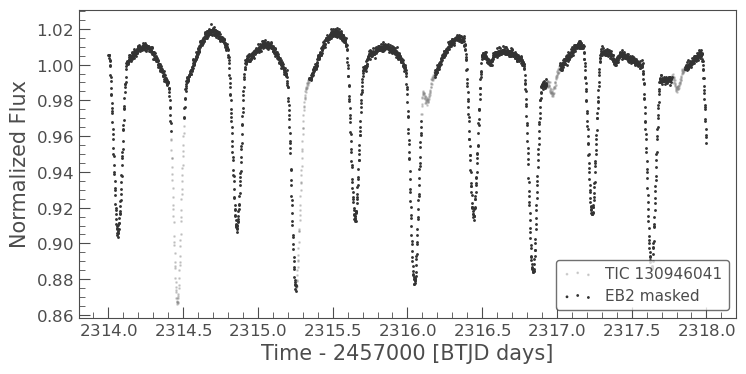

In [8]:
# visualize the mask effect
ax = lc_tess_all.truncate(2314, 2318).scatter(c="gray", alpha=0.3);
ax = lc_tess.truncate(2314, 2318).scatter(ax=ax, label="EB2 masked");

In [10]:
search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

26177

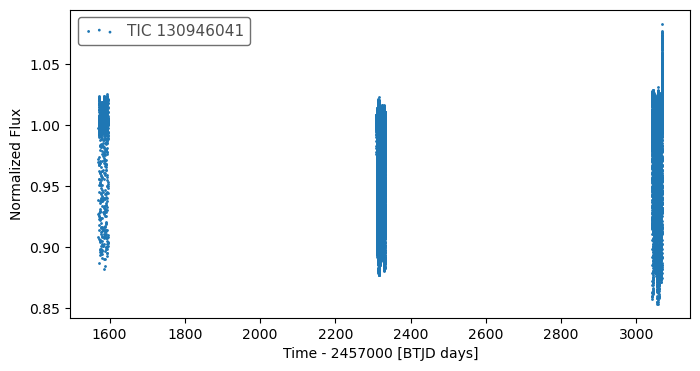

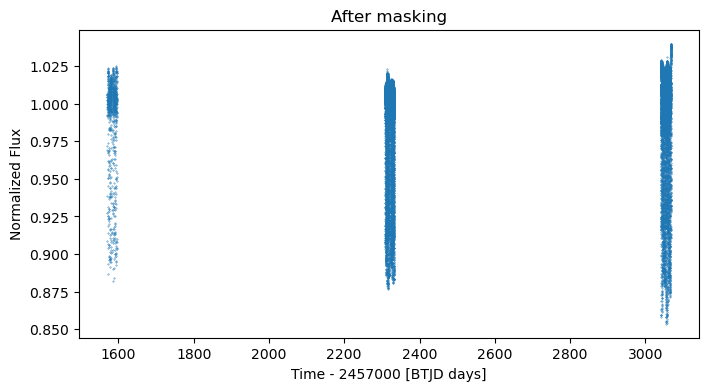

In [12]:
search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value

# mask out extrra data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  # no mask
mask = flux > 1.04  # extreme outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

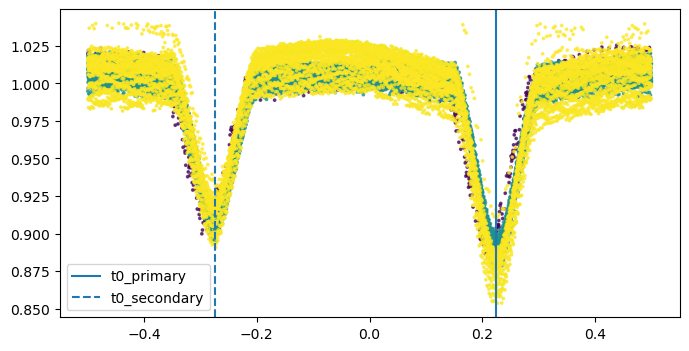

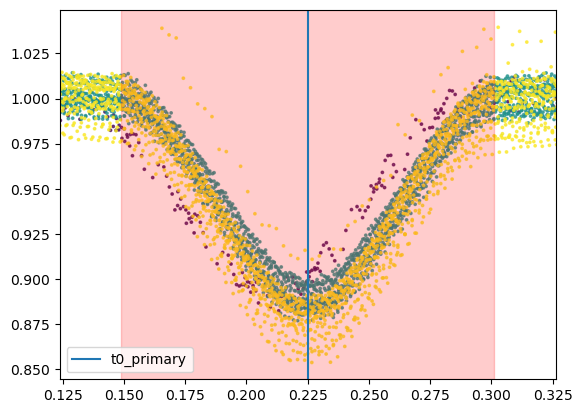

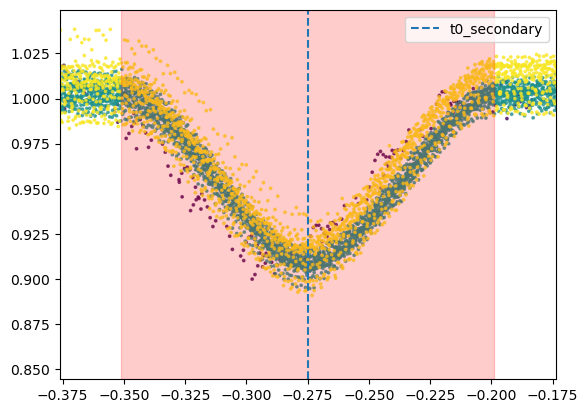

In [25]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0

# epoch=3045.207, duration_hr=2.9, period=0.79257,  label="EB1-deep",  # visual + TCE1
# MCMC on df_primary [clipped LC D*0.8]: p=0.7925692769427999, std_p: 1.4832746524667034e-07 ; t0=1571.0304039002513, std_t0: 0.00014221593059631816

# FILL-IN THE eclipse epoch / period,
# period = 0.79257  # TCE1
period = 0.792569 # MCMC

# t0_primary = 3045.207   # visual, shifted to 1571.0267999999999
t0_primary = 1571.030  # MCMC


t0_secondary = t0_primary + period / 2

duration_hr_primary = 2.9
duration_hr_secondary = 2.9


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
data["flux_original"] = data.flux  # save the original flux 

In [ ]:
# show data to visualize what's changed in each step below
data

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

In [ ]:
# # Uncomment to use the detrended flux
# #
# print("Use deterended flux")
# data.flux = data.flux_detrended

### Now that the data is ready we can start 

- generally the clipped LC window is ***smaller*** than the eclipse duration, to avoid the complication of fitting ingress/egress.

In [28]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.3 * duration_hr_primary / 24 / period   # include ingress/egress
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.3 * duration_hr_secondary / 24 / period
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
start_vals = [1.002, -0.113, midpoint_p, 0.0350, 0.994]
start_vals_s = [1.004, -0.091, midpoint_s, 0.034, 0.97]


# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1571.03 0.22499999999990905
window_width_p (phase): 0.19819515188372663
Secondary: 1570.6337155 -0.2749999999999207
window_width_s (phase): 0.19819515188372663


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.002, -0.113, 1571.03, 0.035, 0.994, 0.792569],


In [ ]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 6000/6000 [15:03<00:00,  6.64it/s]


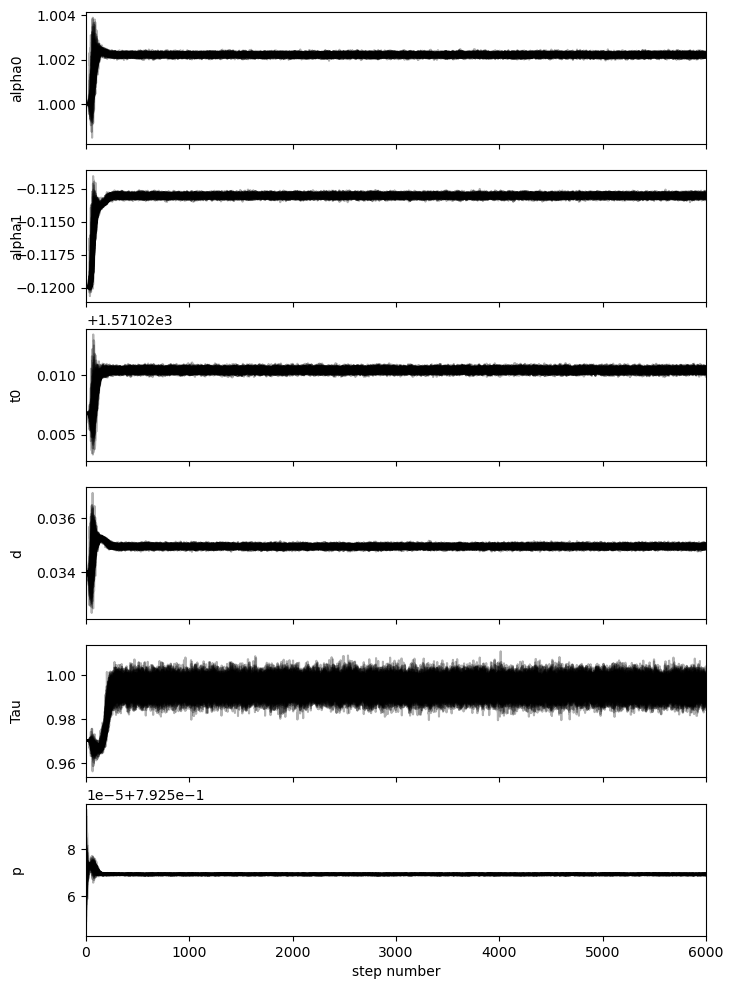

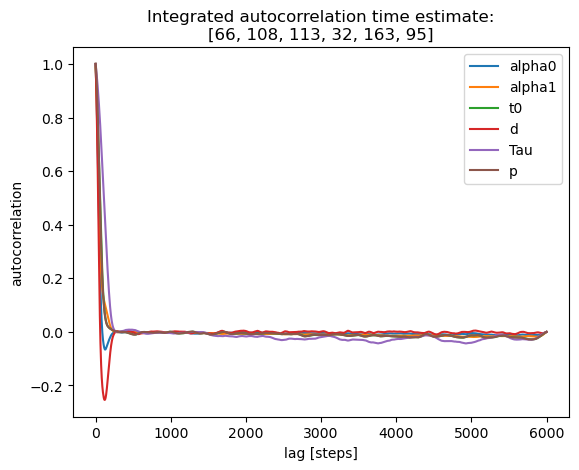

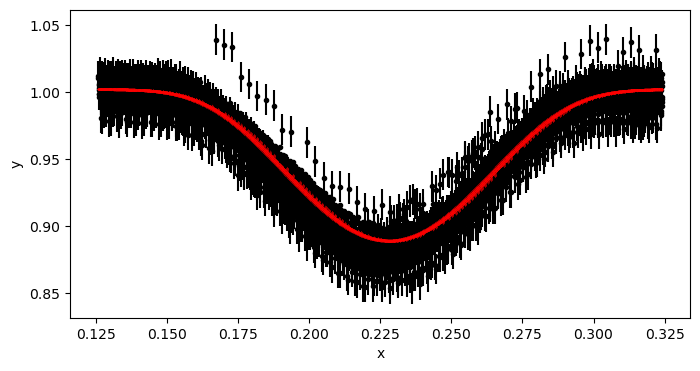

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.002209643919589, -0.11304035063888669, 1571.0304039002513, 0.034951740128971114, 0.9941993773942936, 0.7925692769427999
std_p: 1.4832746524667034e-07 ; std_t0: 0.00014221593059631816


In [24]:
# use MCMC to refine the period (run with large clipped LC window of D*2)

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.12, 1571.0267999999999, 0.034, 0.97, 0.79257],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=6000, discard=1000,
        autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient
        pool=-2,
        plot_chains=True,
        plot_autocorrelation=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [03:51<00:00, 12.98it/s]


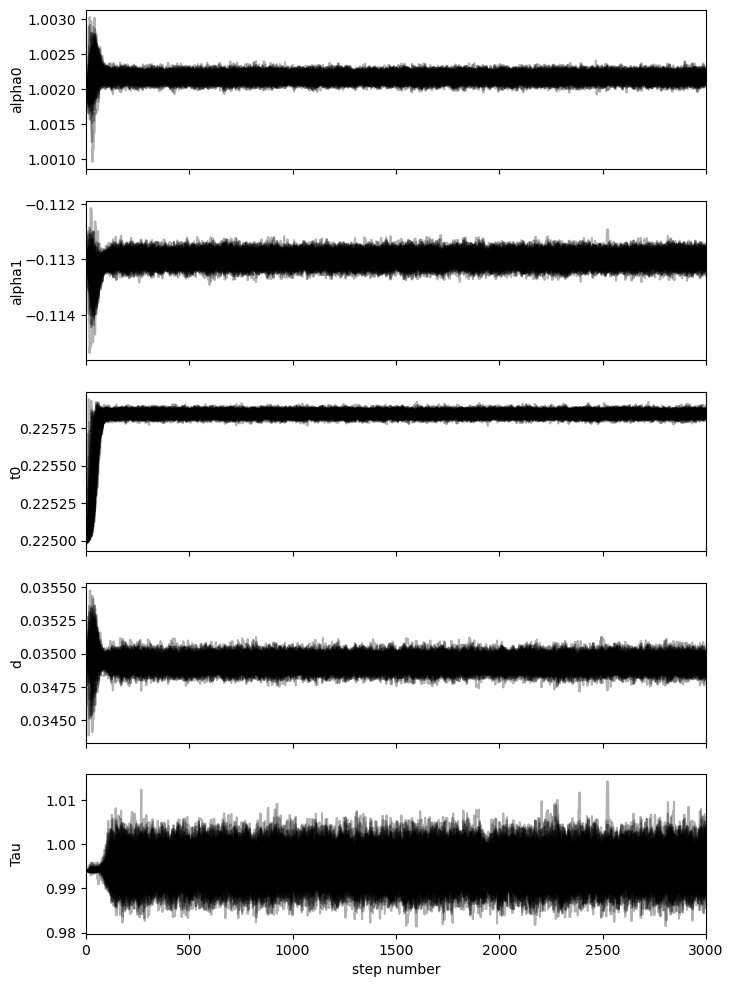

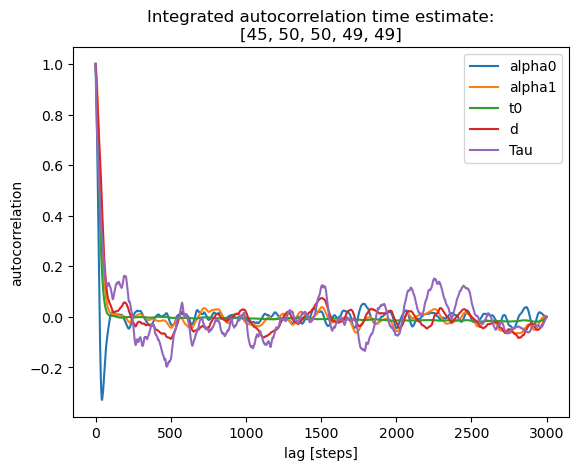

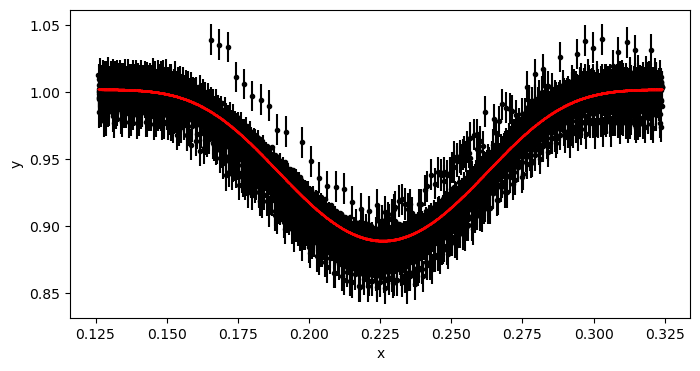

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [03:50<00:00, 13.01it/s]


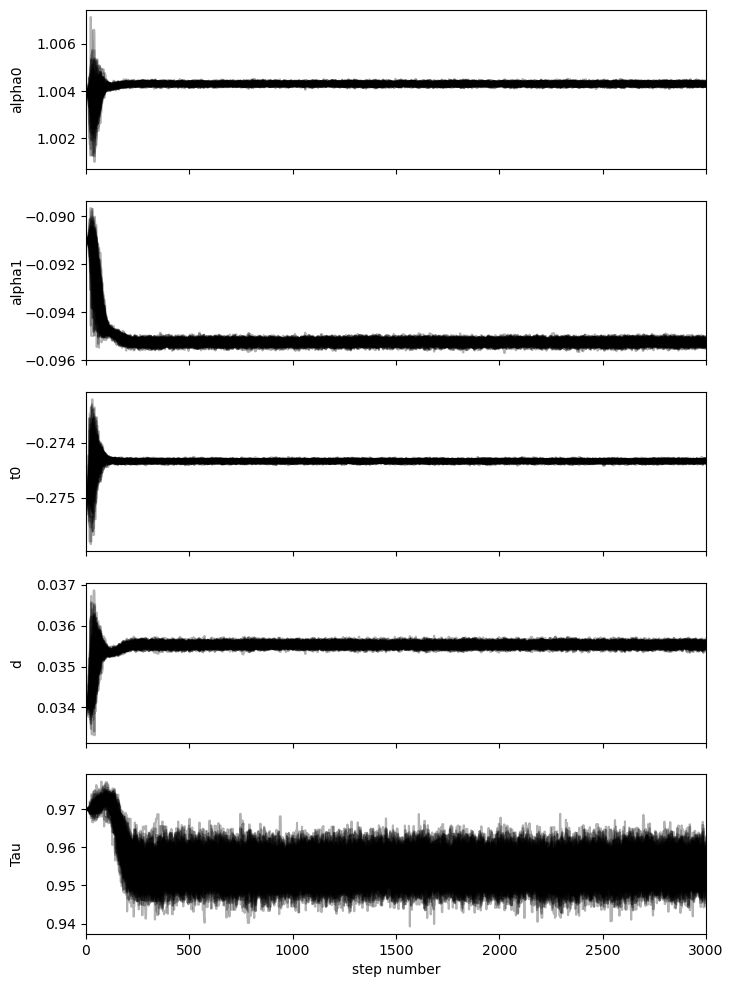

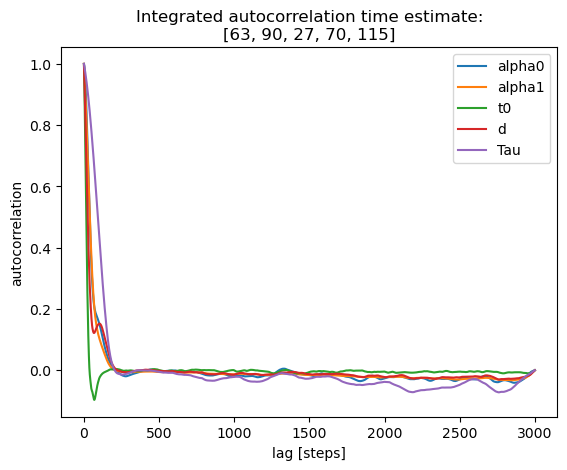

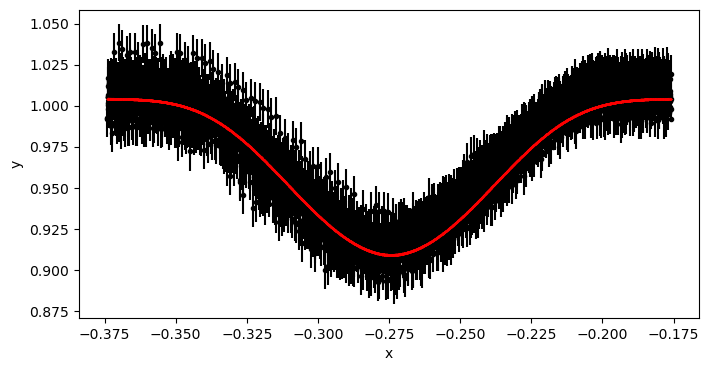

In [30]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, fit_params_stats = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, fit_params_s_stats = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # # initial fit params from TESS data (EB2 removed)
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0021670299940784, -0.1129902529596632, 0.22584453320523987, 0.034929531657227744, 0.994971834614905
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0042921987806457, -0.09526108256267735, -0.27433904005953297, 0.035530834752721646, 0.9544862925141928
    
    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [31]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0021670299940784, -0.1129902529596632, 0.22584453320523987, 0.034929531657227744, 0.994971834614905
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0042921987806457, -0.09526108256267735, -0.27433904005953297, 0.035530834752721646, 0.9544862925141928


1888

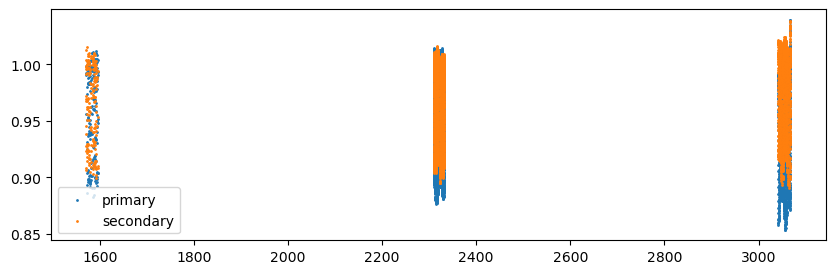

In [32]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1571.03 0.792569 1571.03


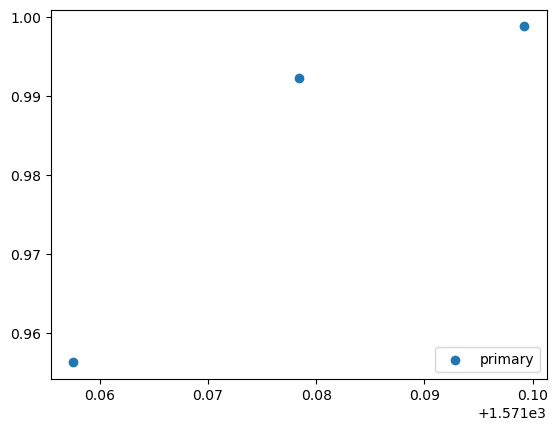

1571.03 0.792569 1571.822569


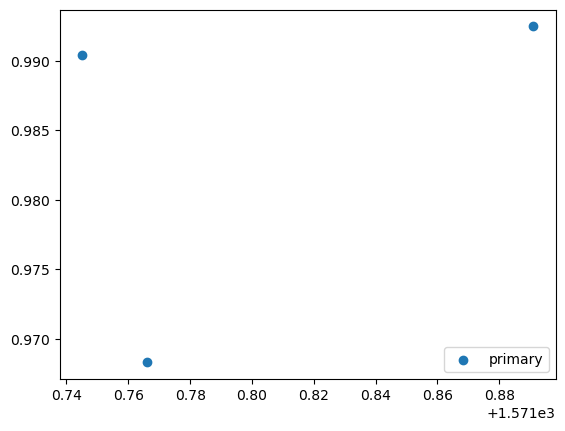

1571.03 0.792569 1572.615138


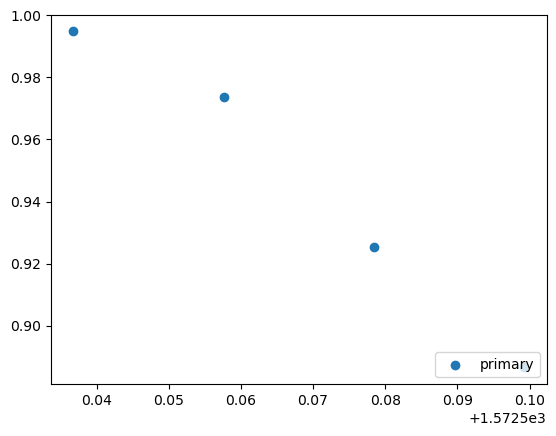

1570.6337155 0.792569 1570.6337155


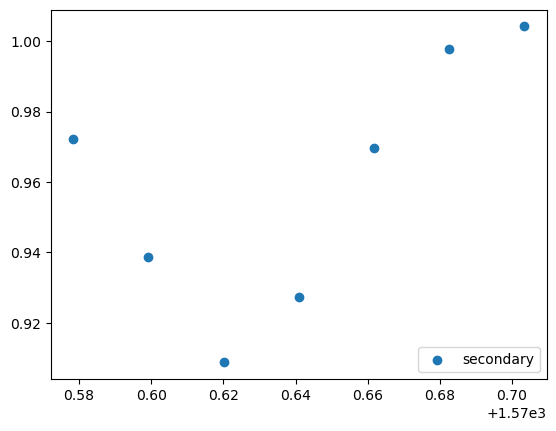

1570.6337155 0.792569 1571.4262845


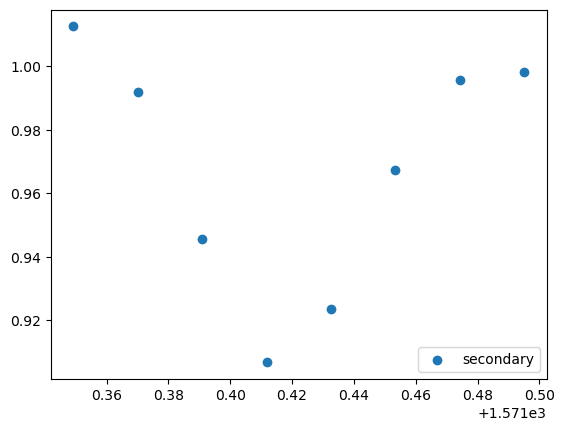

1570.6337155 0.792569 1572.2188535


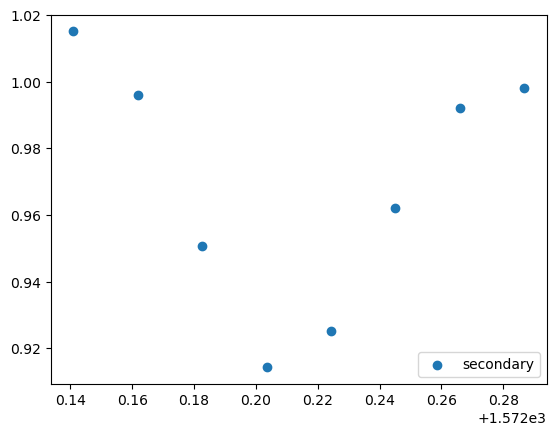

In [33]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux)
    yerr = np.array(data_primary.err)

    print (t0_primary, period, transit_time)

    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

    x = np.array(x[mask])
    y = np.array(y[mask])
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()


if t0_secondary is not None:
    for i in tr_index[0:3]:
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux)
        yerr = np.array(data_secondary.err)

        print (t0_secondary, period, transit_time)

        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit individual eclipses

In [34]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum `min_number_data` (20)
longest_cadence = np.max(sr.exptime)
est_number_data_primary   = int(duration_hr_primary / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for primary: {est_number_data_primary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))

if t0_secondary is not None:
    est_number_data_secondary = int(duration_hr_secondary / longest_cadence.to(u.hr).value)
    print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for secondary:  {est_number_data_secondary}")
    if est_number_data_secondary < 20:
        display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

Expected num of data points of a clipped LC in longest cadence (1800.0 s) for primary: 5


Expected num of data points of a clipped LC in longest cadence (1800.0 s) for secondary:  5


Fitting individual primary eclipses...
Creating new manifest file
Time 1571.03 does not have enough data points: 3
Time 1571.822569 does not have enough data points: 3
Time 1572.615138 does not have enough data points: 4
1573.407707 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.73it/s]


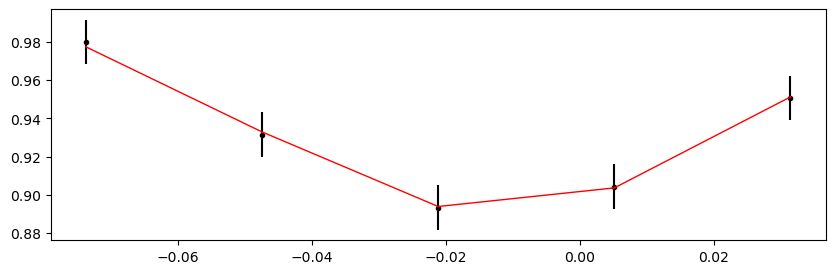

1574.200276 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.34it/s]


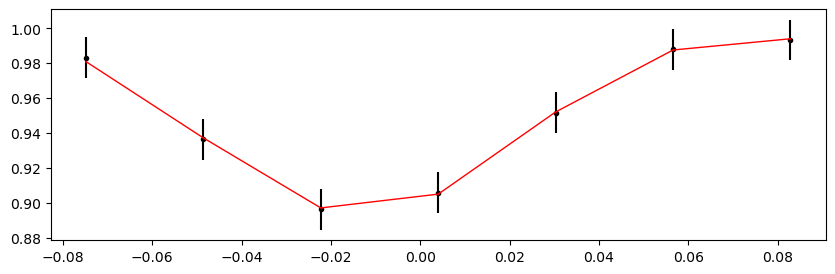

1574.992845 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.57it/s]


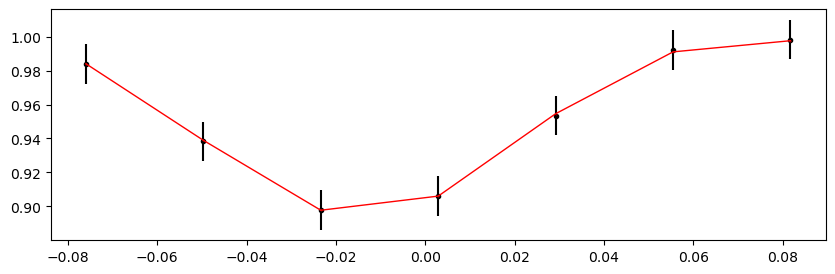

1575.785414 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.17it/s]


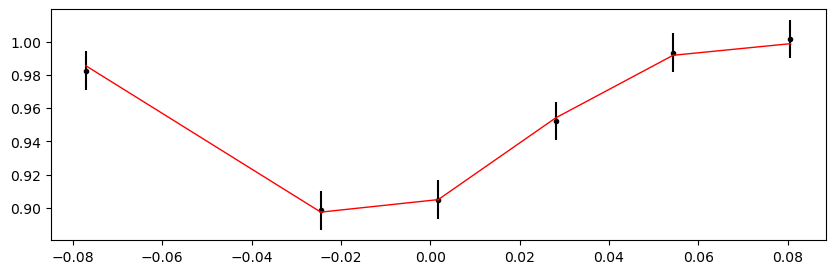

1576.577983 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.54it/s]


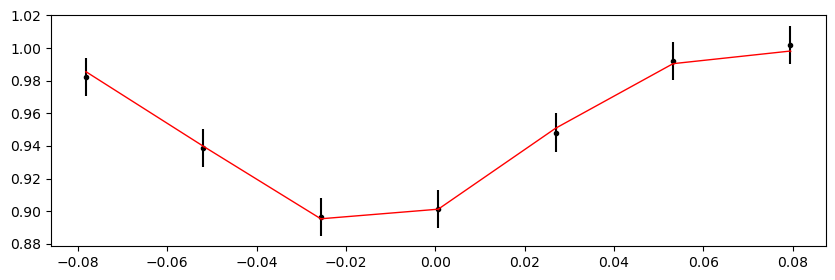

1577.3705519999999 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.11it/s]


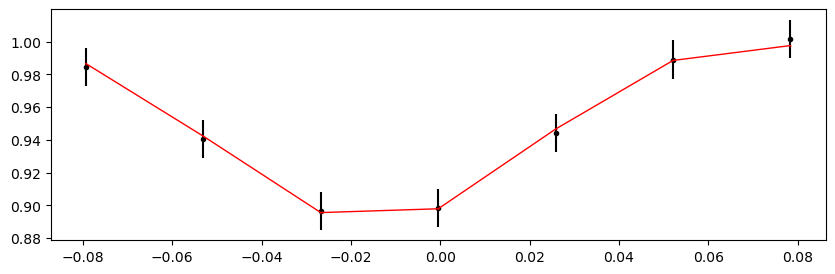

1578.163121 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.27it/s]


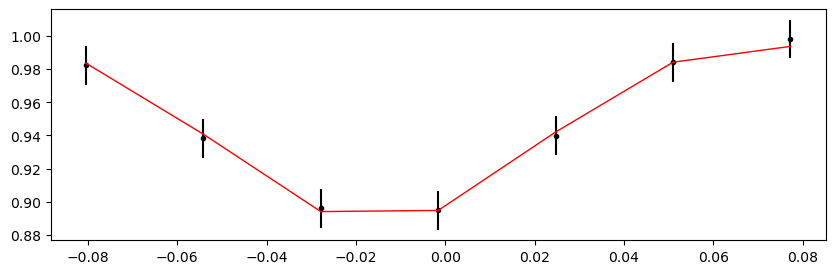

1578.95569 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.58it/s]


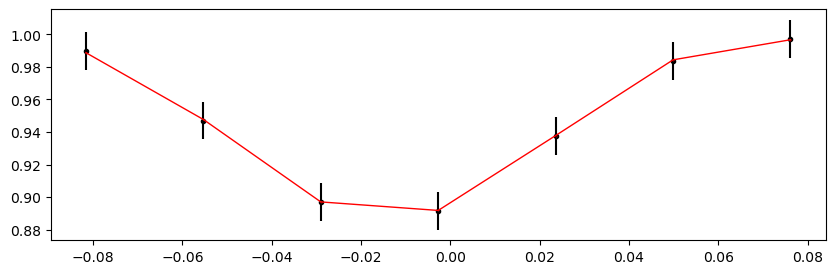

1579.748259 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.31it/s]


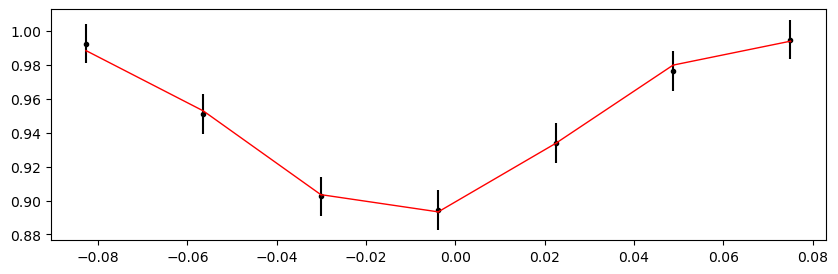

1580.540828 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.79it/s]


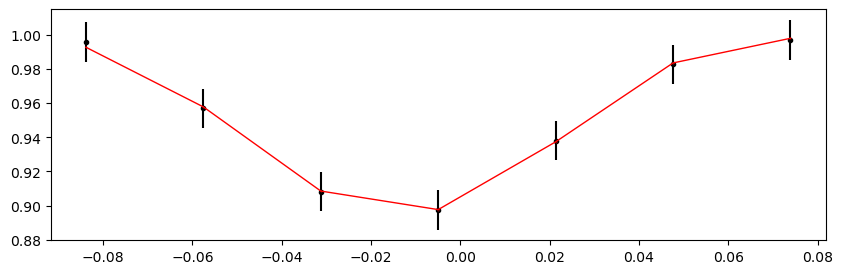

1581.3333969999999 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.94it/s]


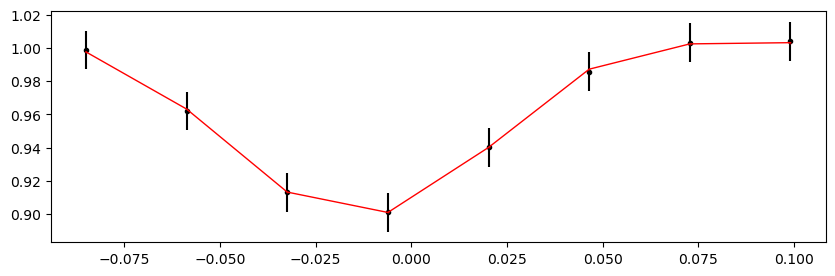

1582.918535 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.80it/s]


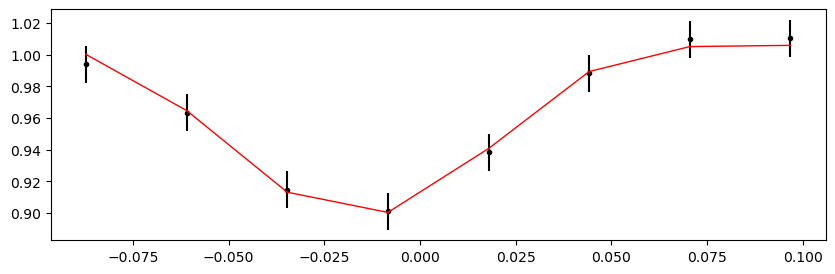

1584.503673 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.16it/s]


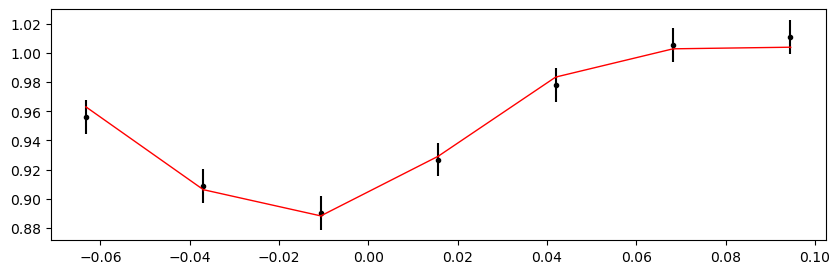

1585.296242 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.84it/s]


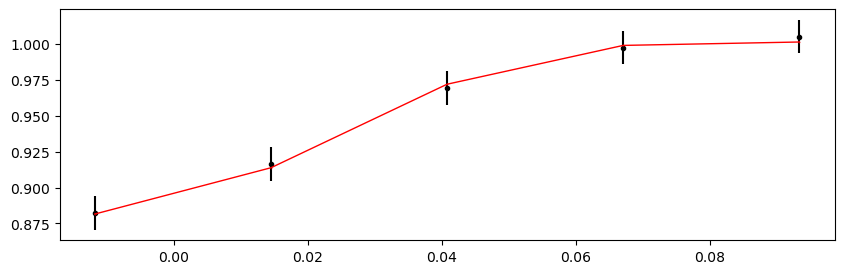

Time 1586.088811 does not have enough data points: 3
Time 1586.88138 does not have enough data points: 3
1587.673949 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.54it/s]


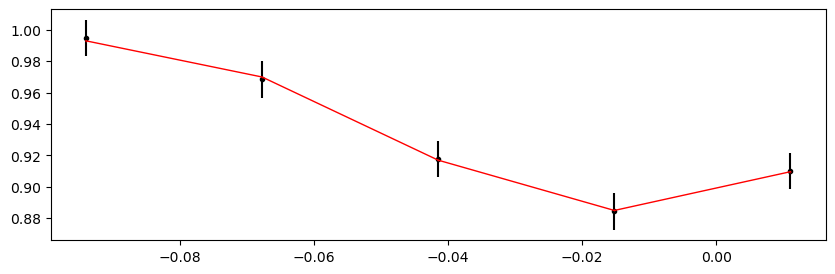

1588.466518 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.16it/s]


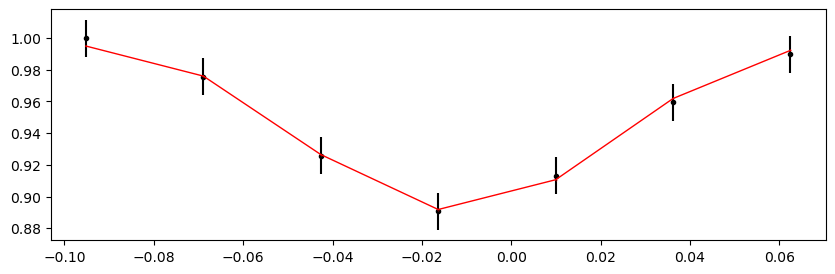

1589.259087 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.18it/s]


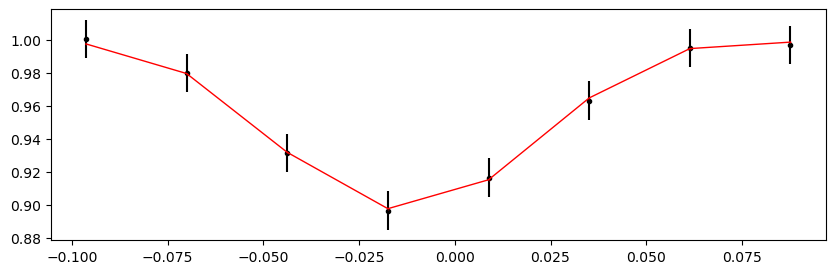

1590.0516559999999 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.30it/s]


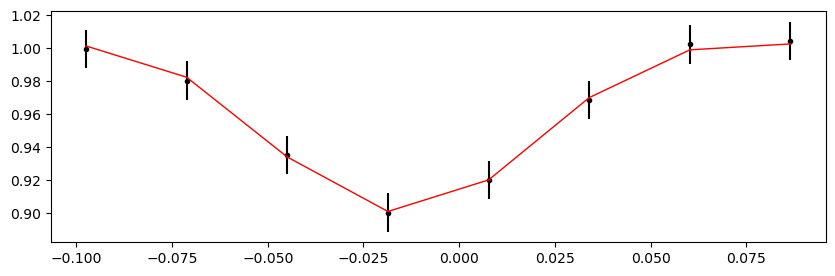

1590.844225 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.05it/s]


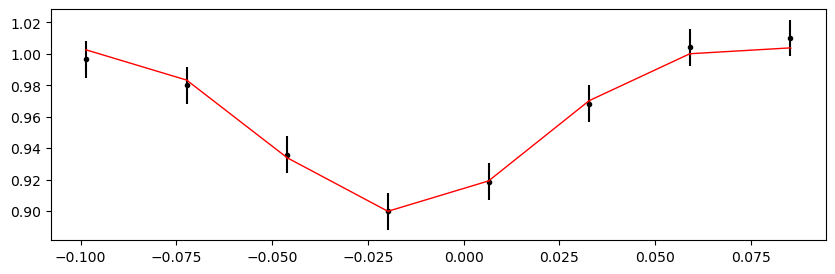

1591.636794 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.60it/s]


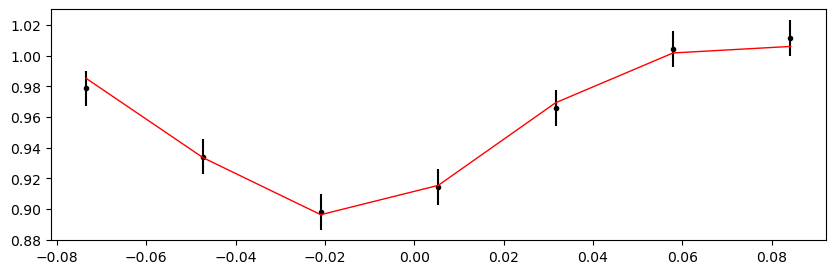

1592.429363 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.36it/s]


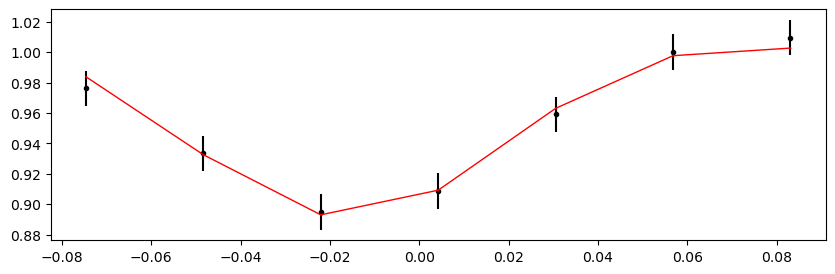

1593.221932 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.34it/s]


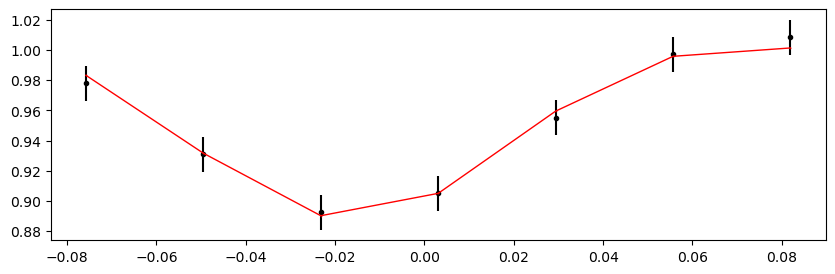

1594.0145009999999 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 438.76it/s]


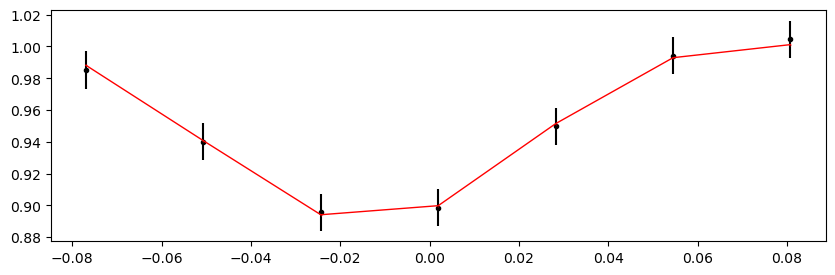

1594.80707 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.31it/s]


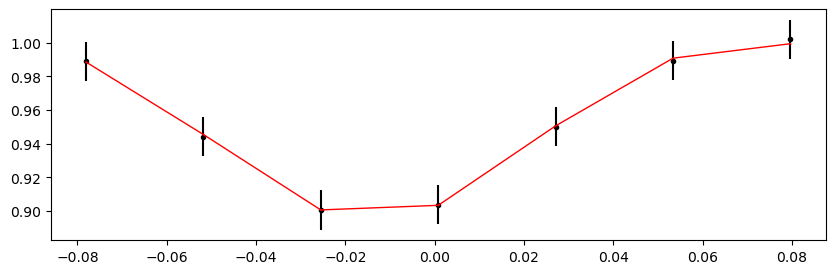

1595.599639 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.41it/s]


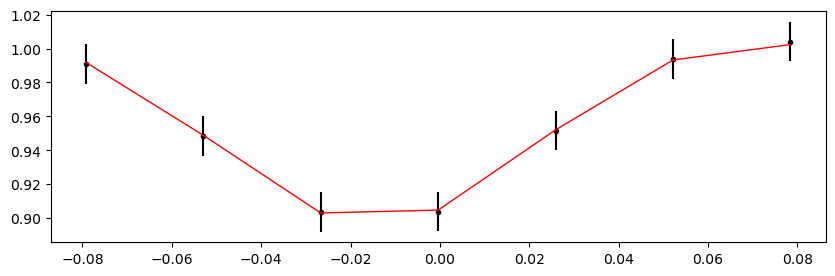

2309.704308 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.42it/s]


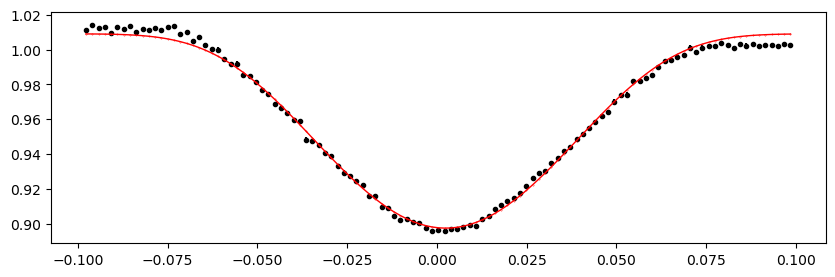

2310.496877 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.41it/s]


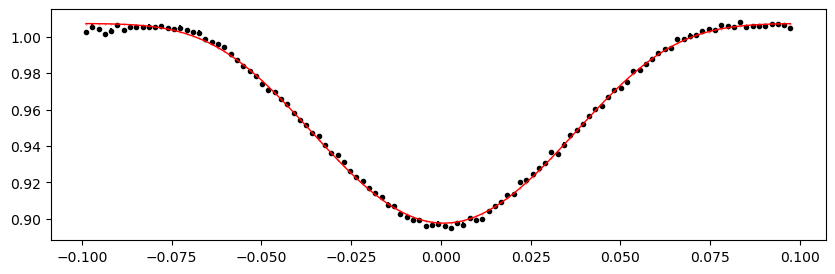

2311.2894459999998 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.37it/s]


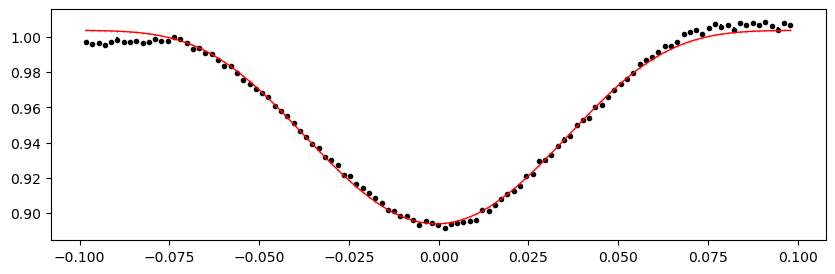

2312.082015 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.39it/s]


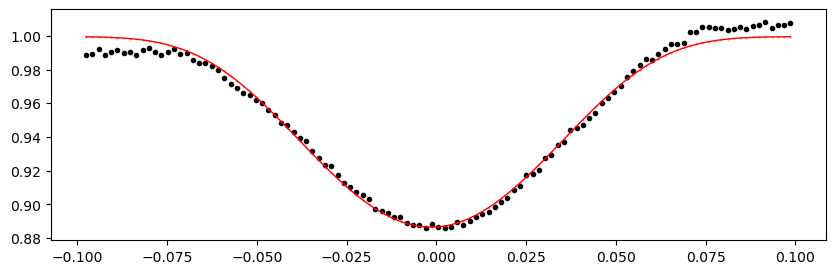

2312.874584 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.33it/s]


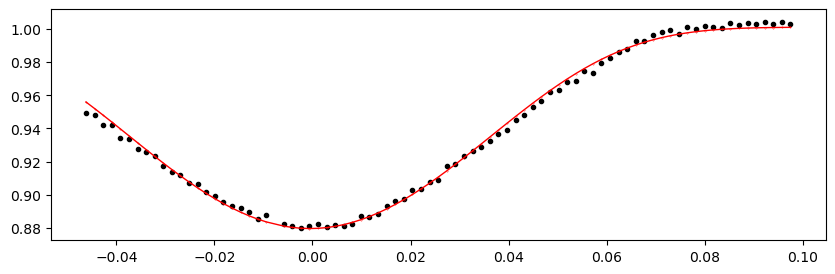

2313.667153 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.43it/s]


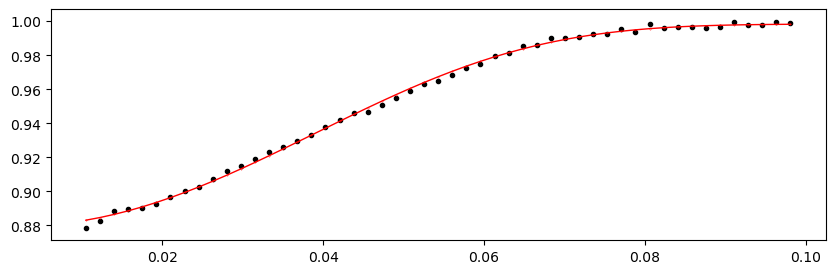

2314.459722 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.01it/s]


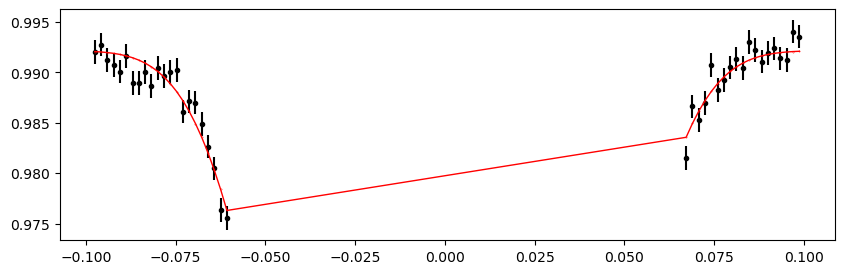

2315.252291 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.66it/s]


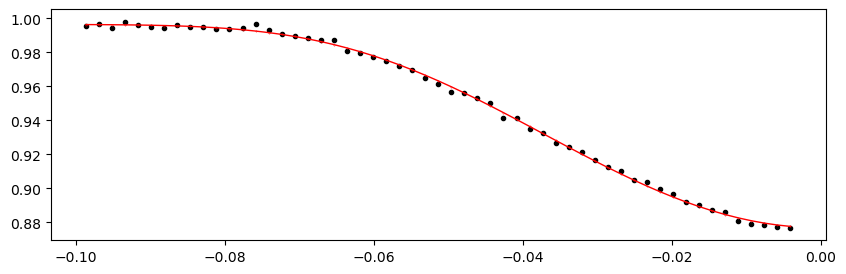

2316.04486 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.50it/s]


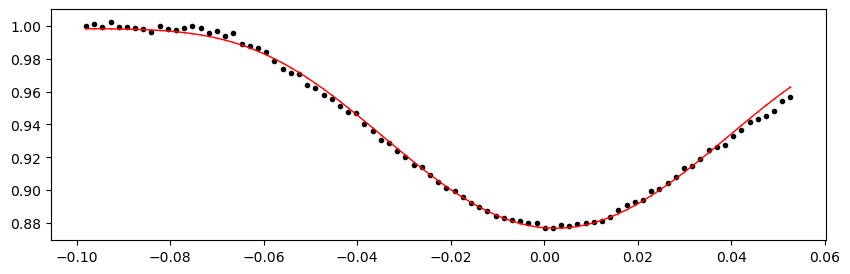

2316.837429 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.44it/s]


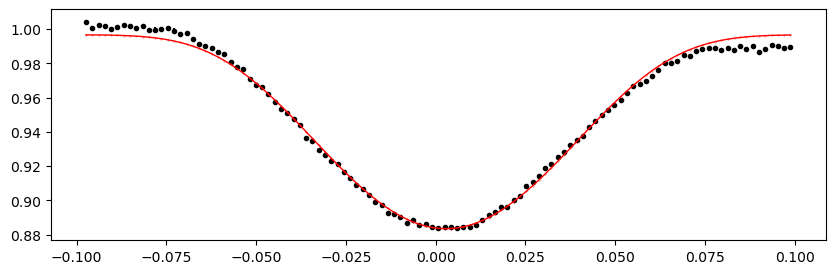

2317.629998 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.73it/s]


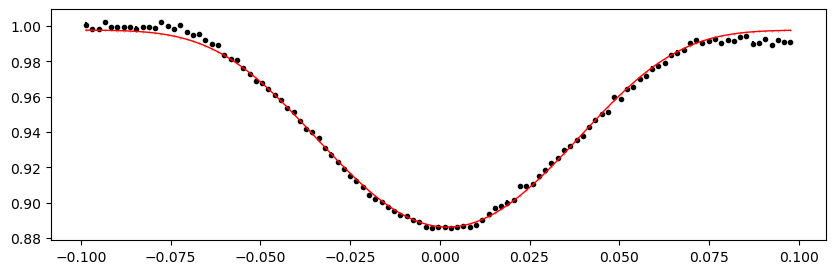

2318.422567 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.46it/s]


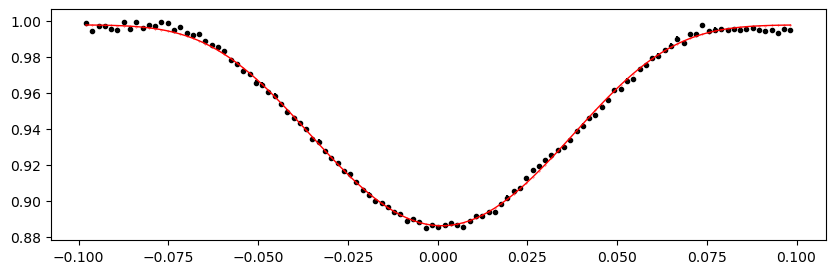

2322.385412 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 527.51it/s]


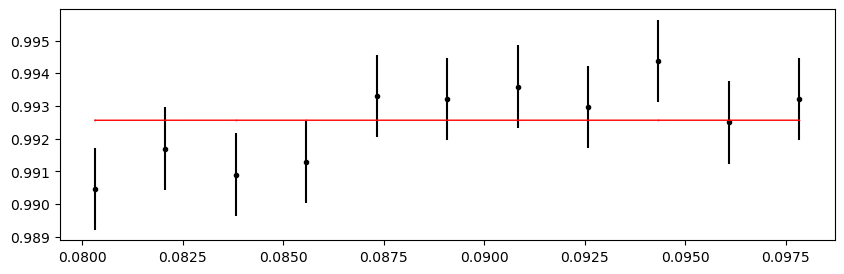

2323.177981 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.78it/s]


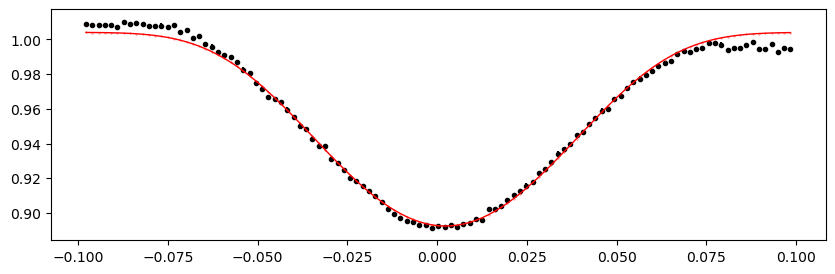

2323.97055 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.11it/s]


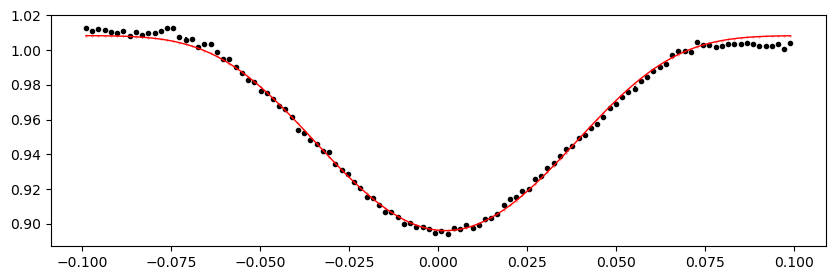

2324.763119 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.43it/s]


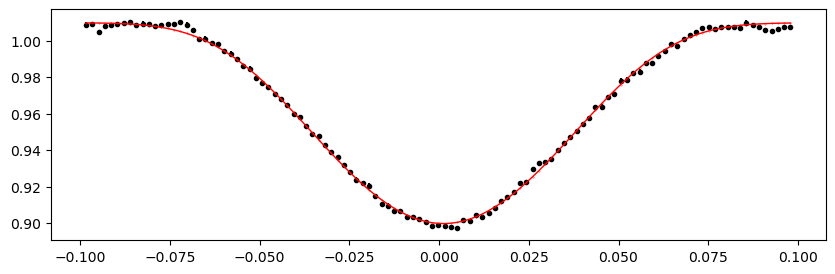

2325.555688 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.35it/s]


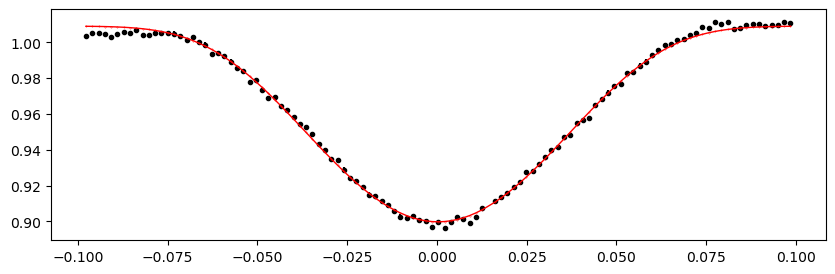

2326.348257 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 357.10it/s]


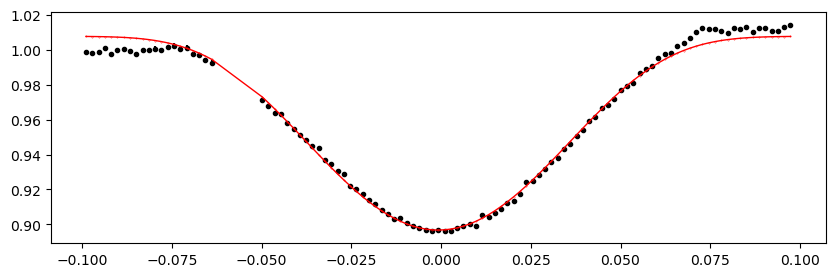

2327.140826 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.14it/s]


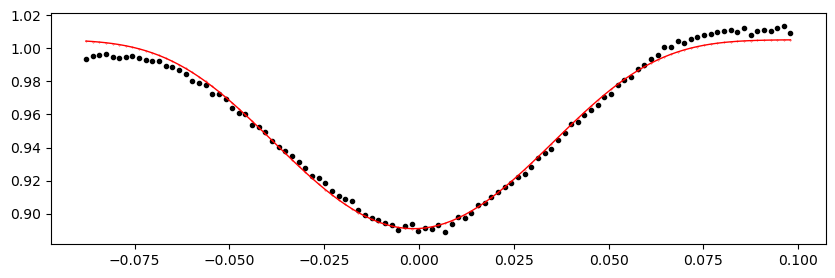

2327.933395 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.88it/s]


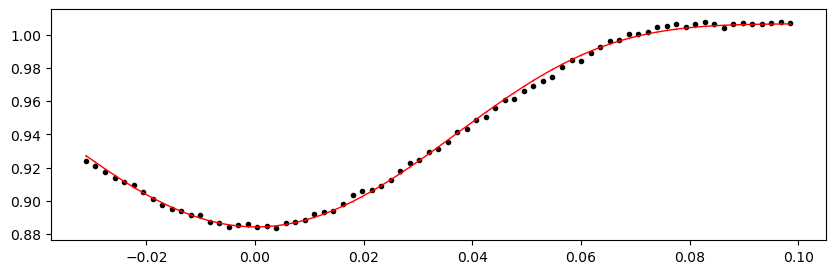

2328.725964 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.92it/s]


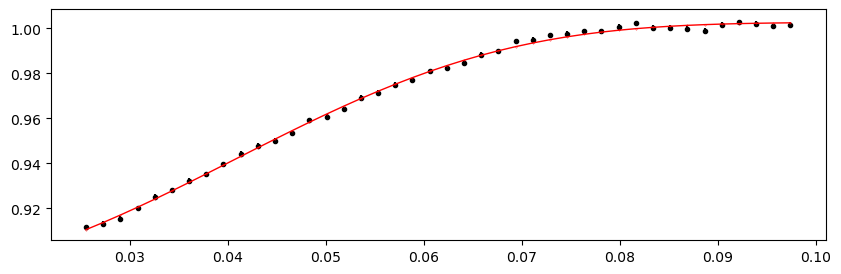

2329.518533 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.03it/s]


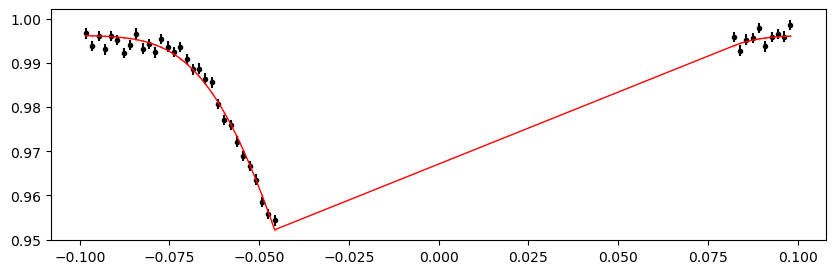

2330.3111019999997 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.78it/s]


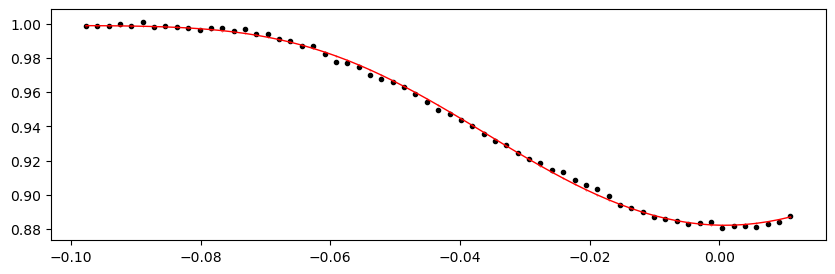

2331.103671 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.90it/s]


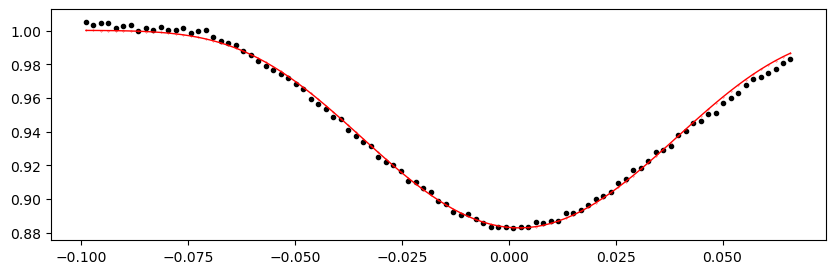

2331.89624 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.26it/s]


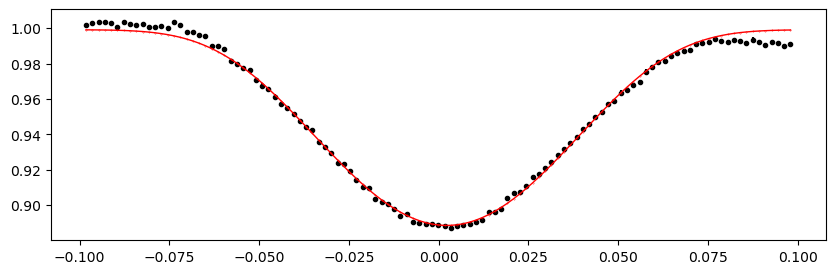

3041.245495 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.22it/s]


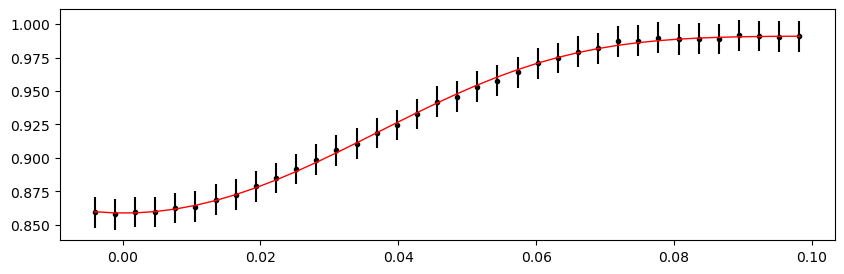

3042.038064 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.25it/s]


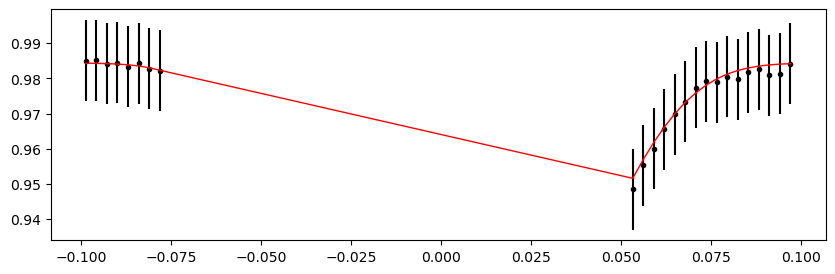

3042.8306329999996 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.29it/s]


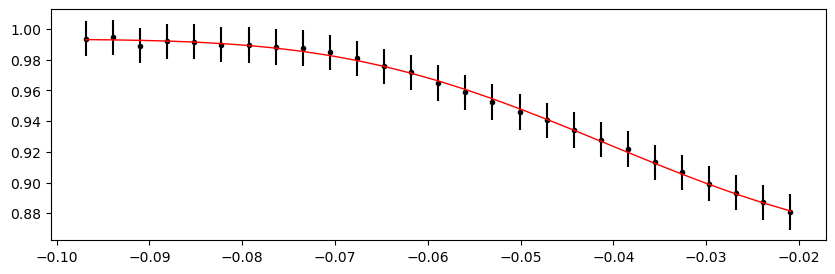

3043.6232019999998 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.80it/s]


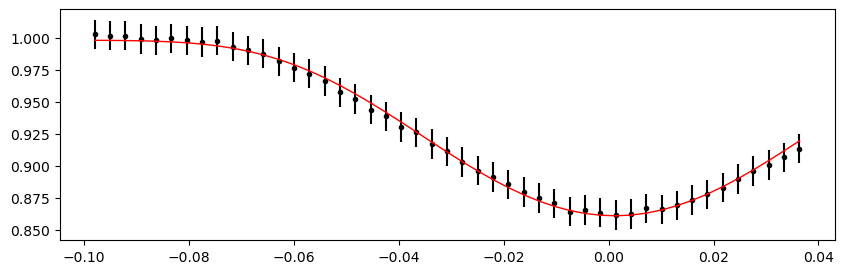

3044.415771 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.94it/s]


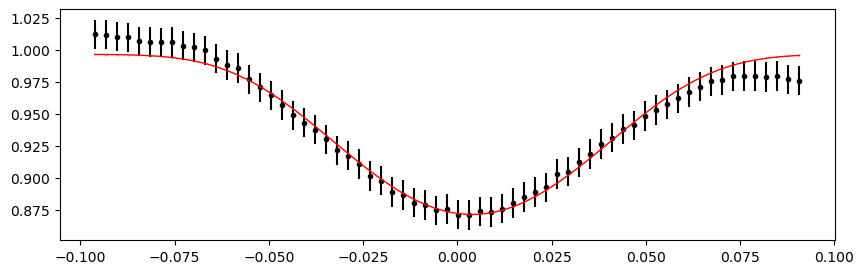

3045.20834 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.08it/s]


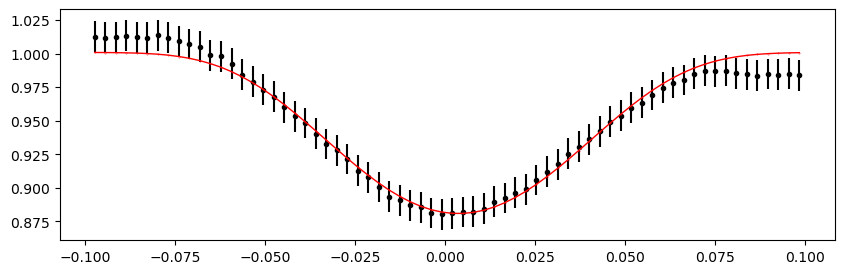

3046.000909 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.01it/s]


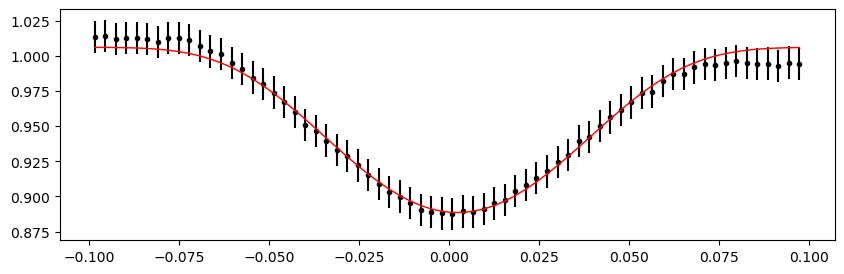

3046.7934779999996 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.96it/s]


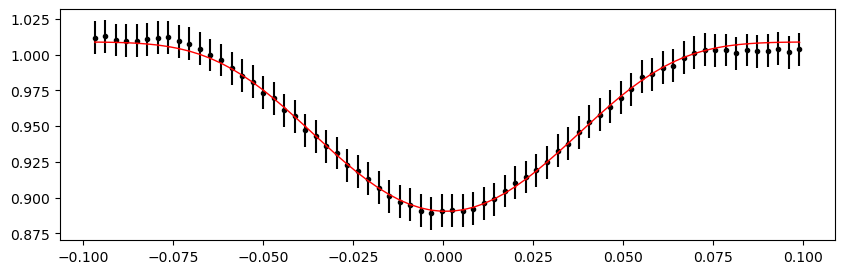

3047.586047 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 368.35it/s]


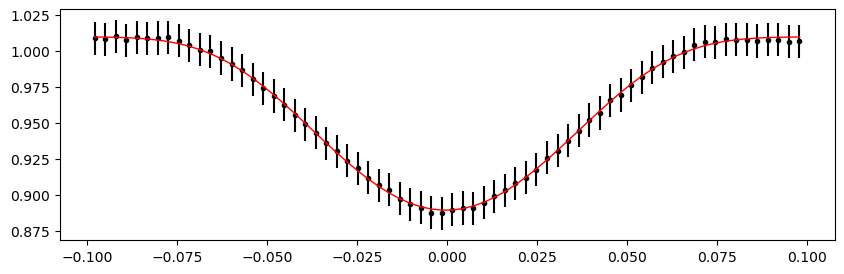

3048.378616 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.82it/s]


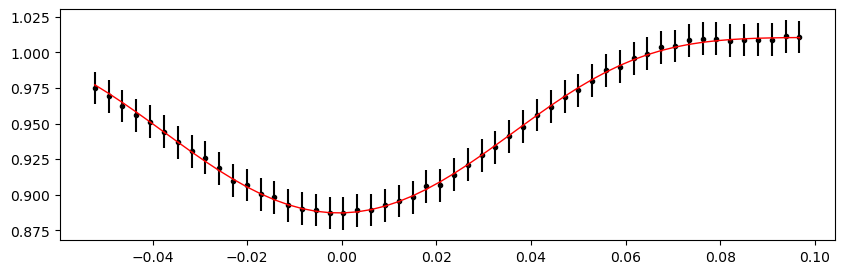

3049.171185 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.07it/s]


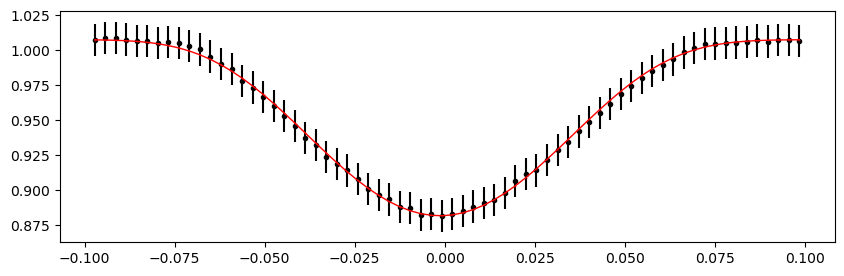

3049.963754 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.10it/s]


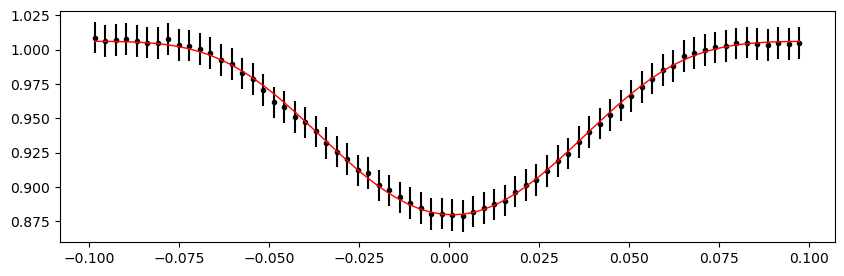

3050.7563229999996 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.98it/s]


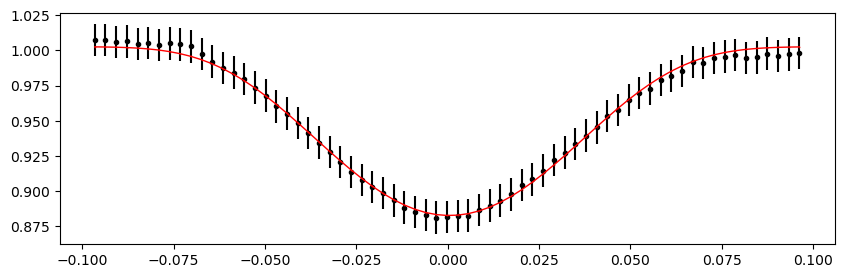

3051.548892 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.58it/s]


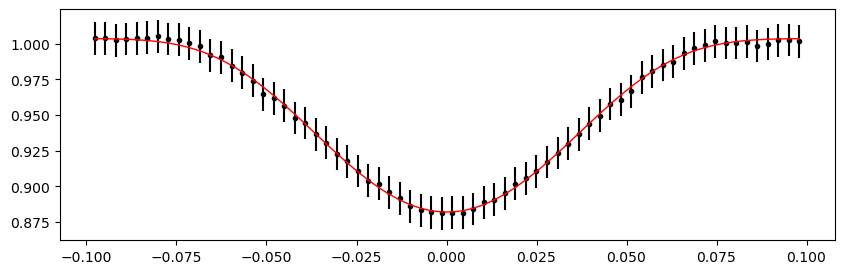

3052.341461 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 373.53it/s]


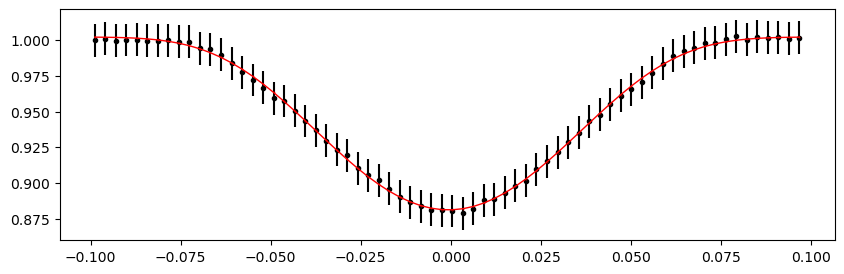

3053.13403 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.19it/s]


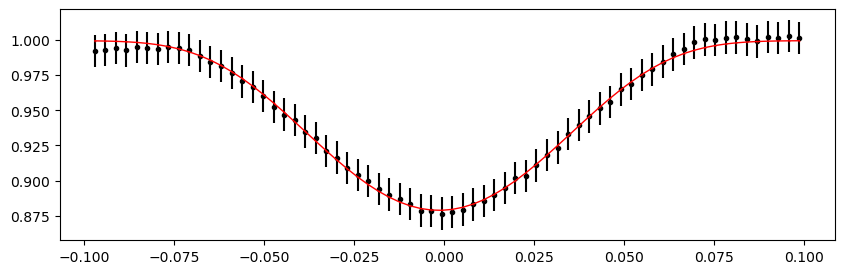

3053.926599 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.04it/s]


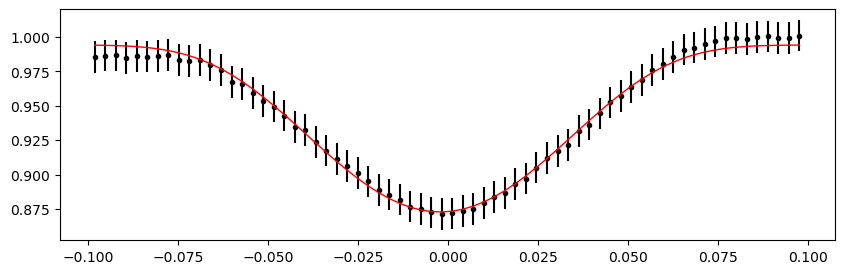

3054.7191679999996 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.33it/s]


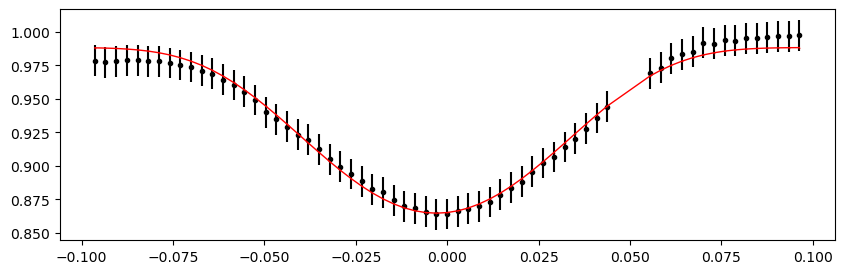

3055.511737 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.60it/s]


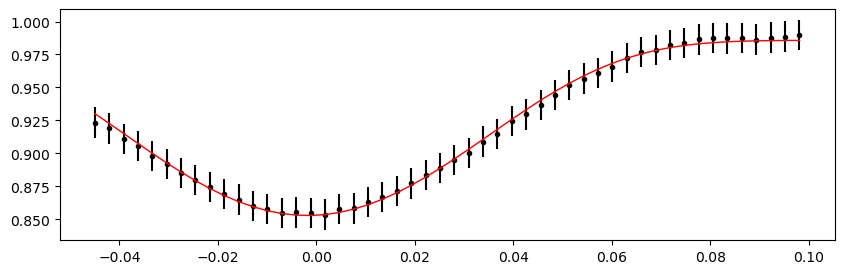

3056.304306 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.84it/s]


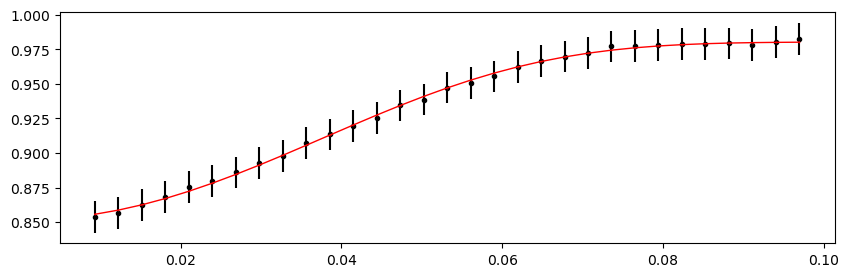

3057.096875 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 537.91it/s]


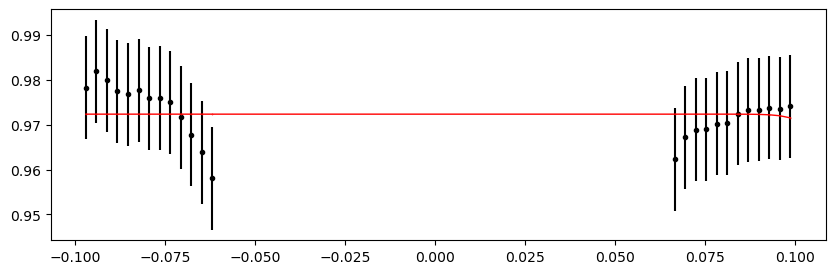

3057.889444 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.95it/s]


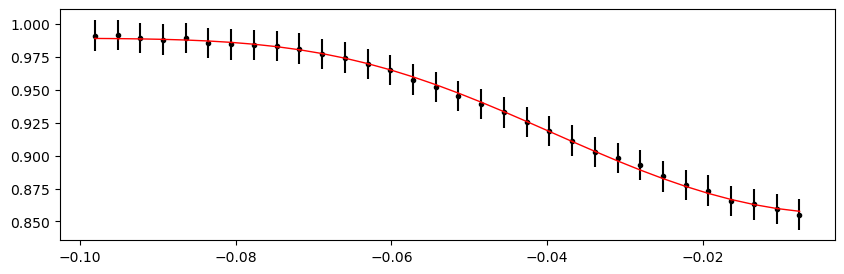

3058.6820129999996 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.88it/s]


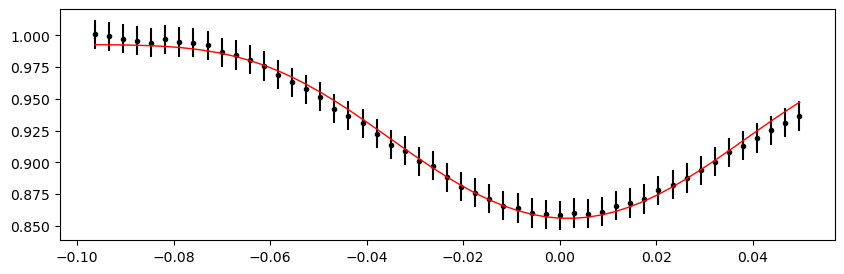

3059.474582 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.33it/s]


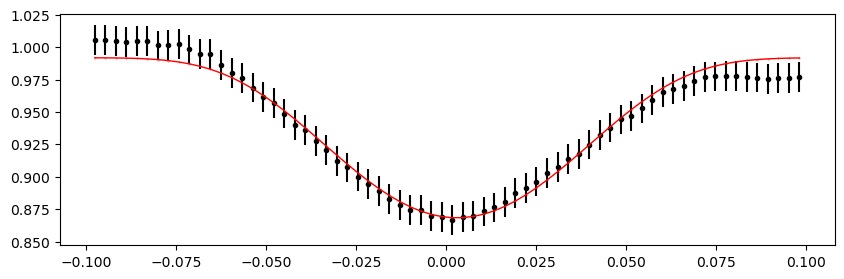

3060.267151 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.28it/s]


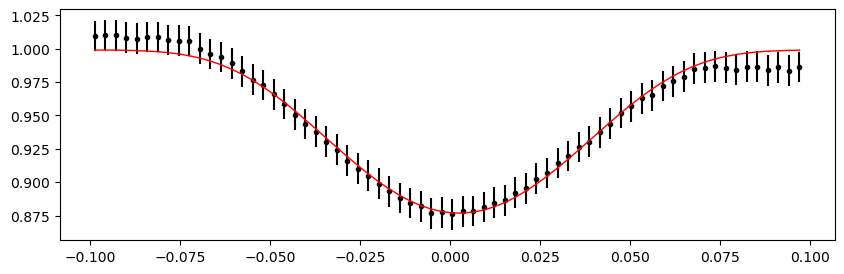

3061.05972 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.61it/s]


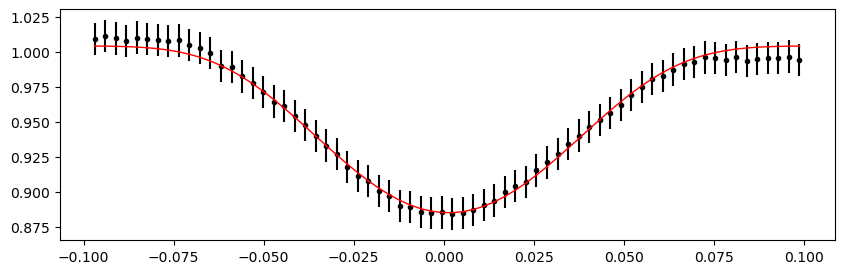

3061.852289 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.16it/s]


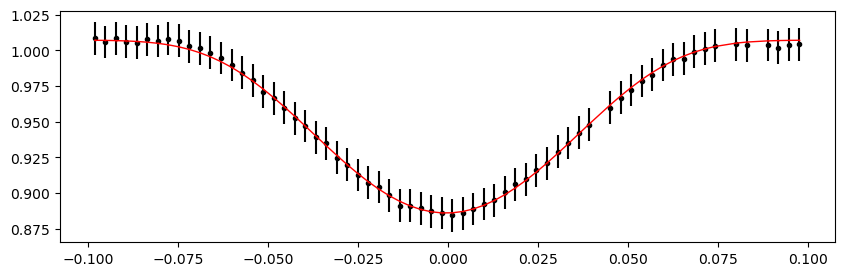

3062.6448579999997 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.17it/s]


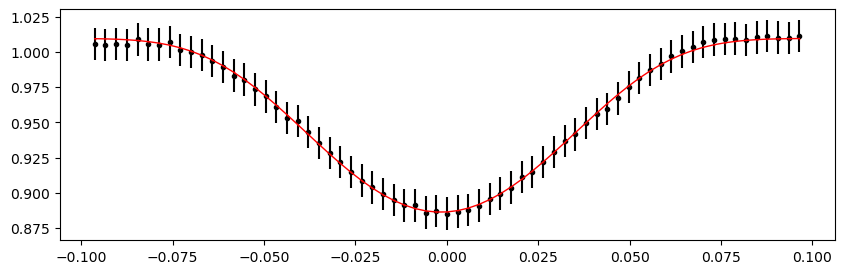

3063.437427 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.50it/s]


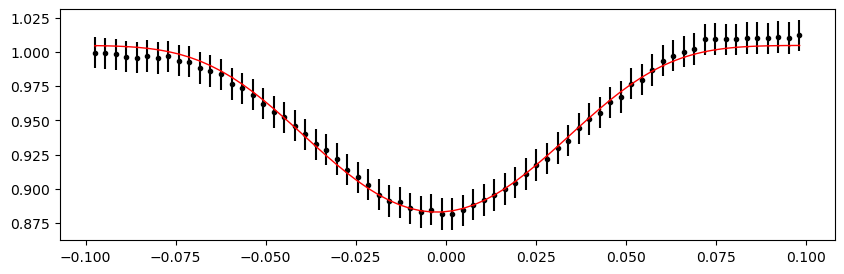

3064.229996 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.60it/s]


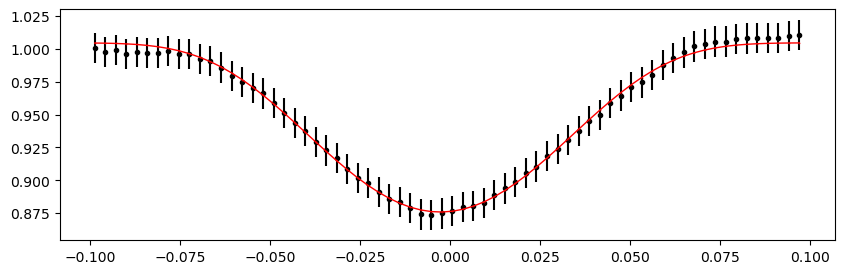

3065.022565 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.23it/s]


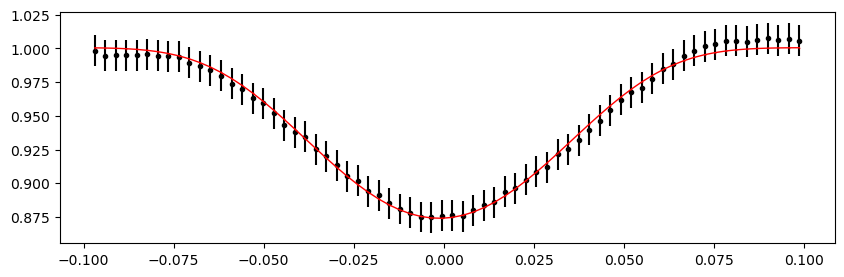

3065.815134 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.93it/s]


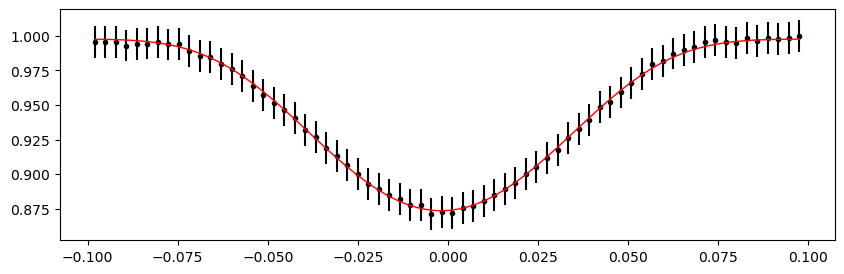

3066.6077029999997 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.66it/s]


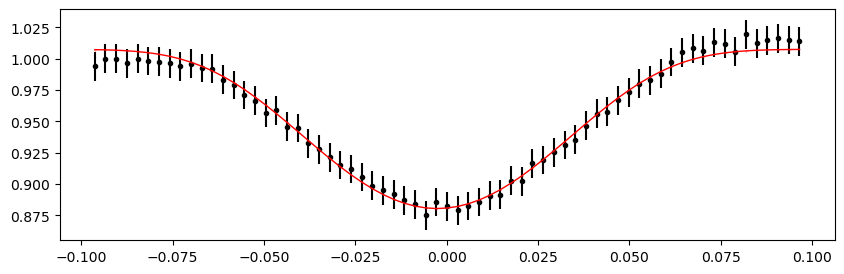

3067.400272 1.0021670299940784 -0.1129902529596632 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 373.40it/s]


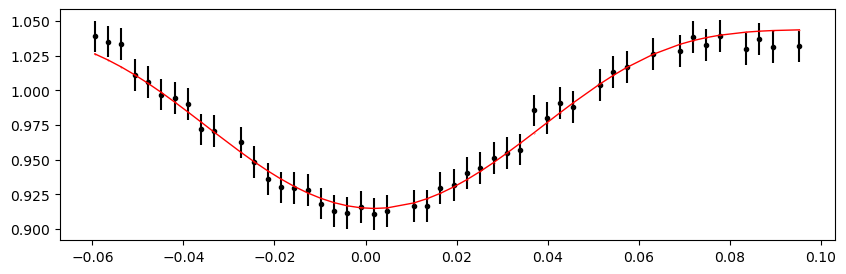

In [35]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=4,  # for 30 min cadence data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Creating new manifest file
1570.6337155 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.87it/s]


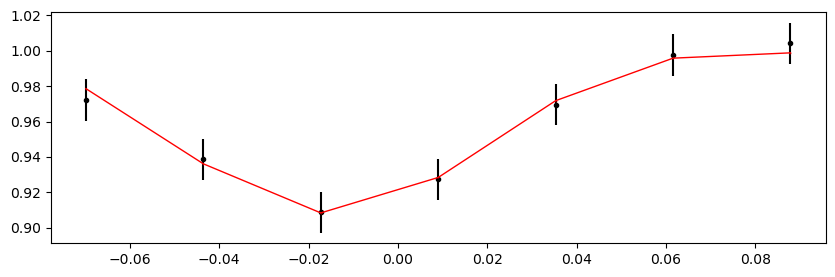

1571.4262845 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.72it/s]


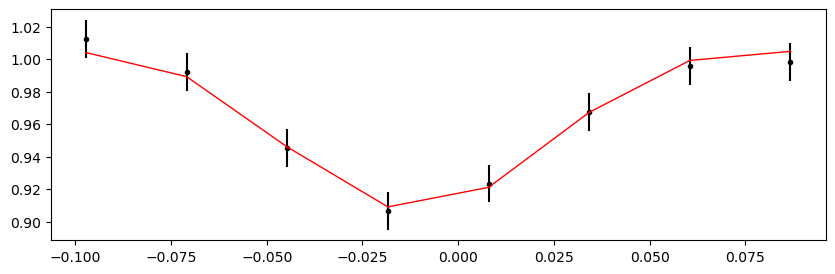

1572.2188535 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.82it/s]


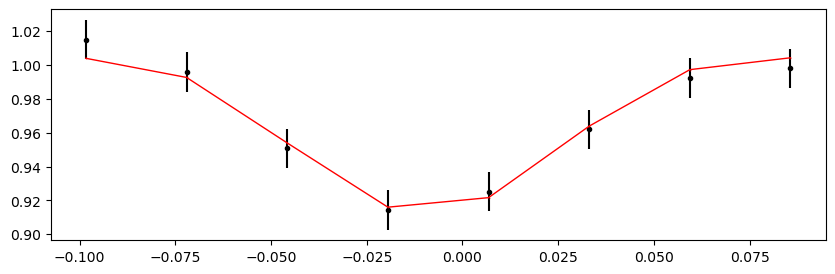

1573.0114225000002 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.75it/s]


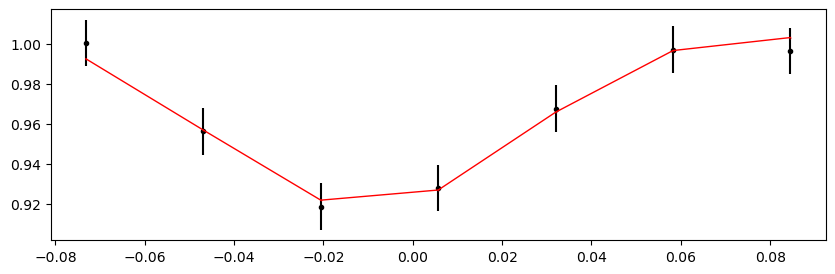

1573.8039915000002 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.18it/s]


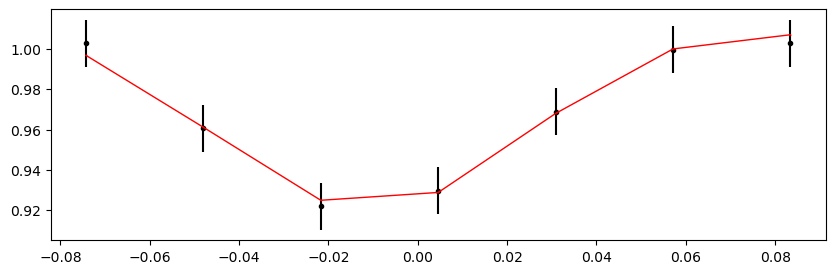

1574.5965605000001 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.82it/s]


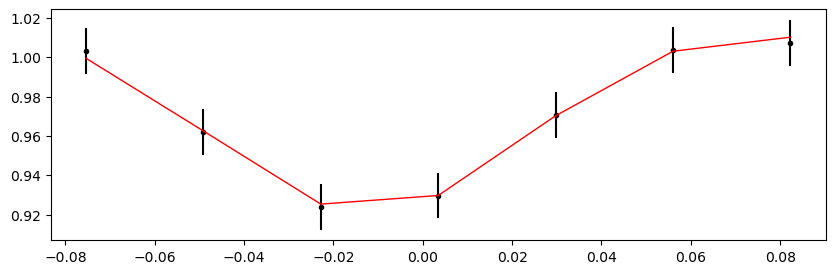

1575.3891295 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.41it/s]


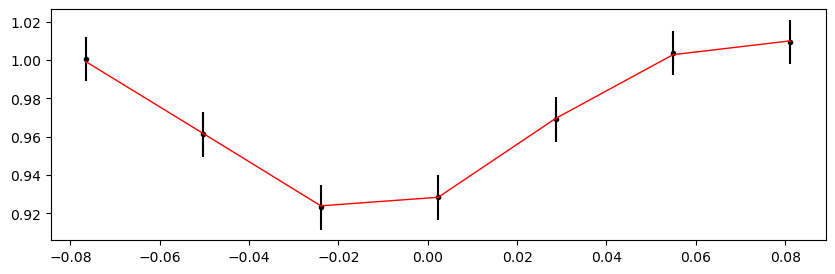

1576.1816985 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.41it/s]


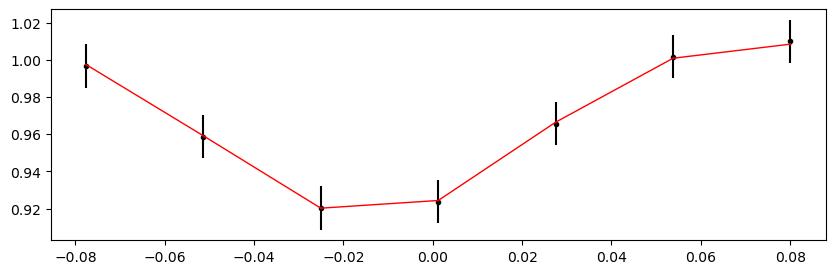

1576.9742675 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.78it/s]


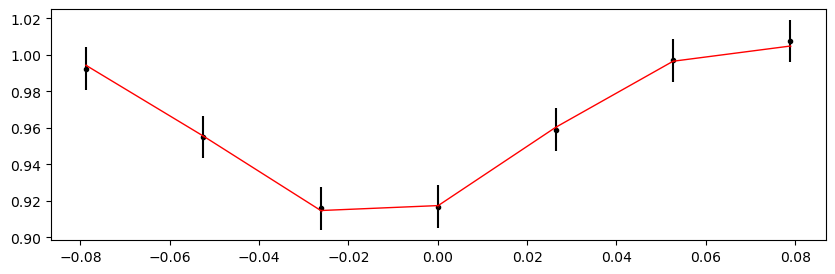

1577.7668365000002 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.72it/s]


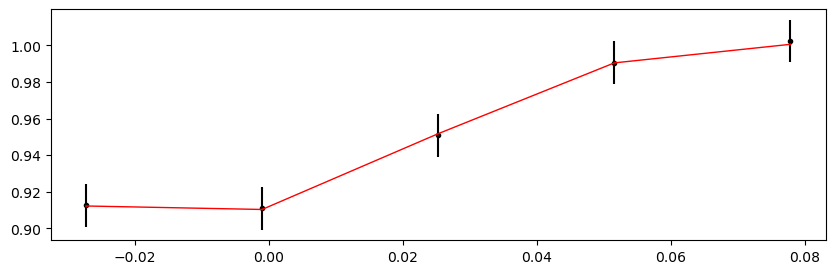

Time 1578.5594055000001 does not have enough data points: 3
Time 1579.3519745 does not have enough data points: 3
Time 1580.1445435 does not have enough data points: 4
1580.9371125 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.53it/s]


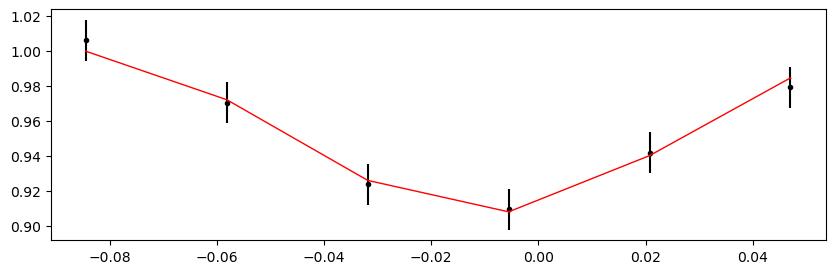

1581.7296815000002 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.03it/s]


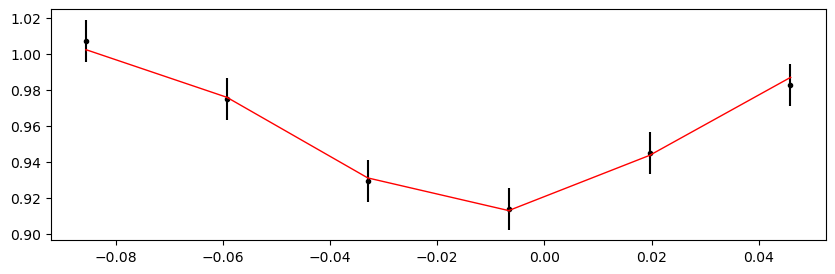

1584.8999575 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.42it/s]


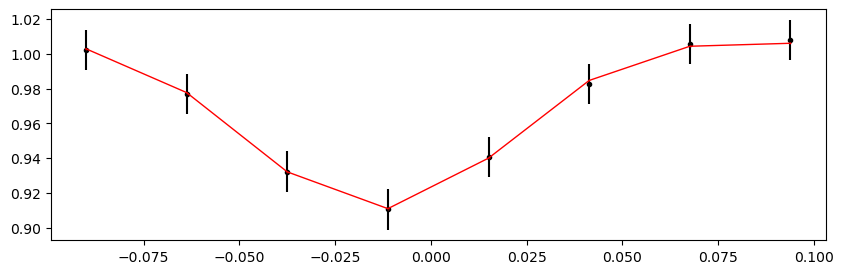

1585.6925265000002 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.77it/s]


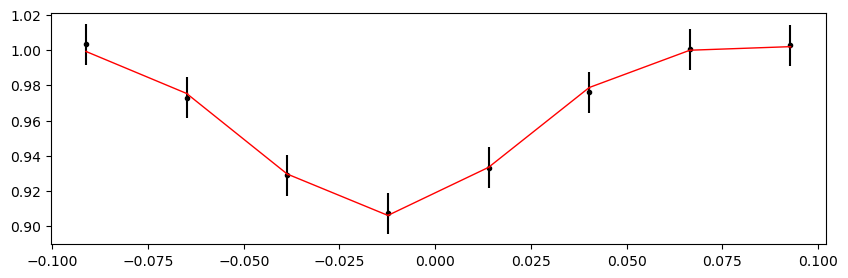

1586.4850955000002 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.64it/s]


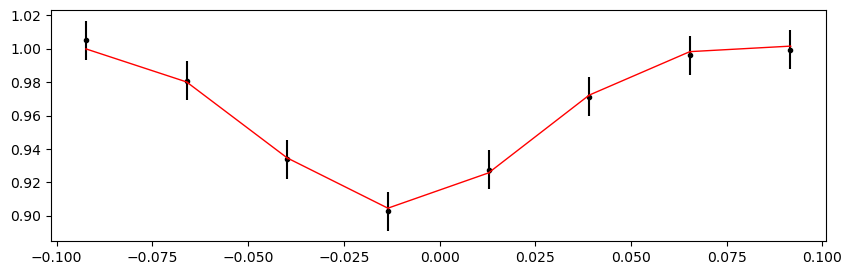

1587.2776645000001 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.01it/s]


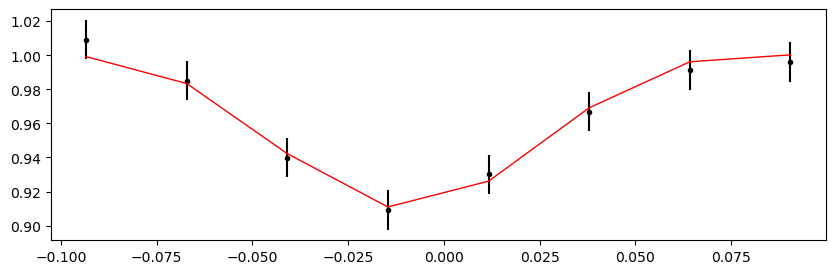

1588.0702335 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.59it/s]


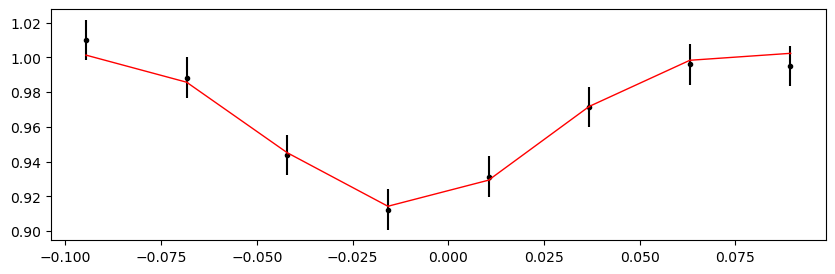

1588.8628025 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.86it/s]


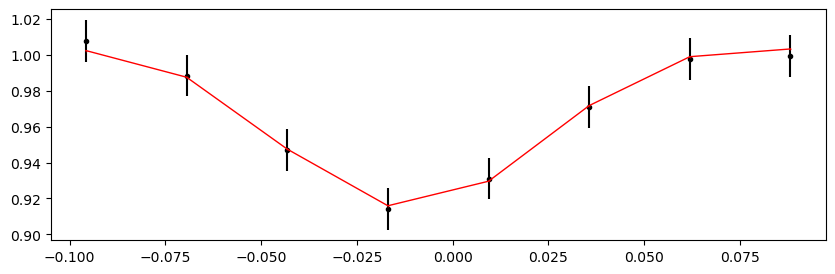

1589.6553715 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.82it/s]


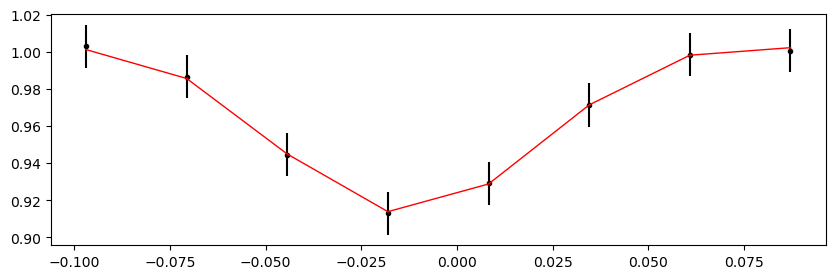

1590.4479405000002 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.42it/s]


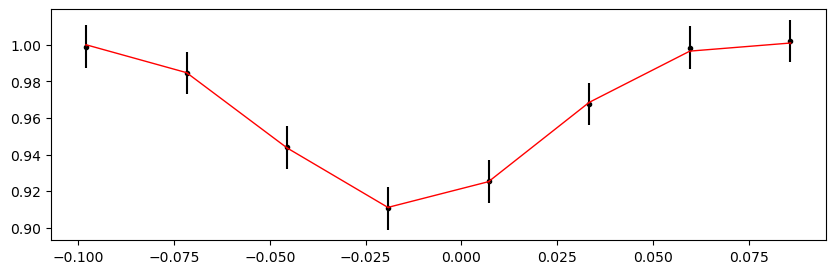

1591.2405095000001 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.40it/s]


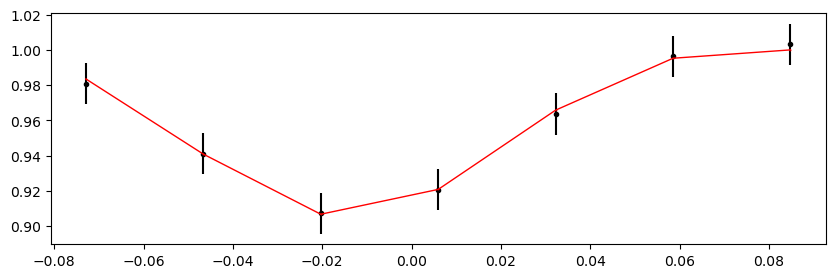

1592.0330785 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.46it/s]


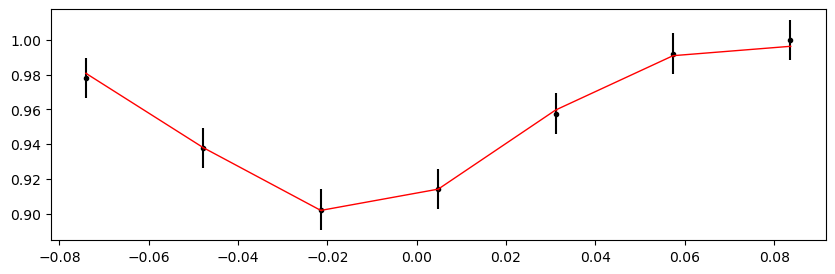

1592.8256475 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.51it/s]


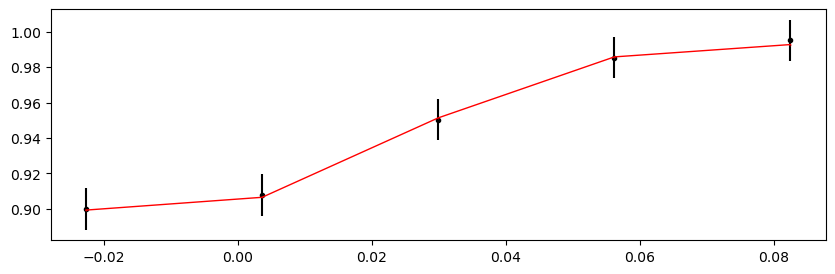

Time 1593.6182165 does not have enough data points: 2
Time 1594.4107855000002 does not have enough data points: 2
Time 1595.2033545000002 does not have enough data points: 4
2309.3080235 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.20it/s]


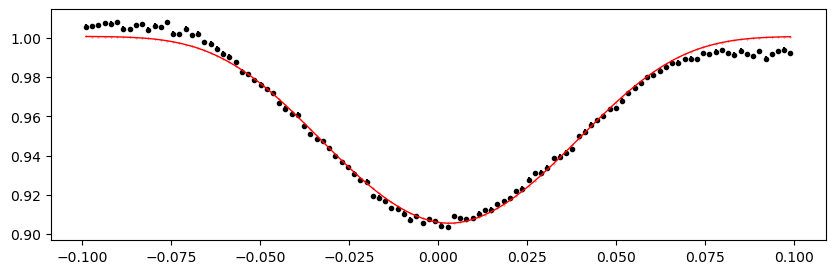

2310.1005925 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.63it/s]


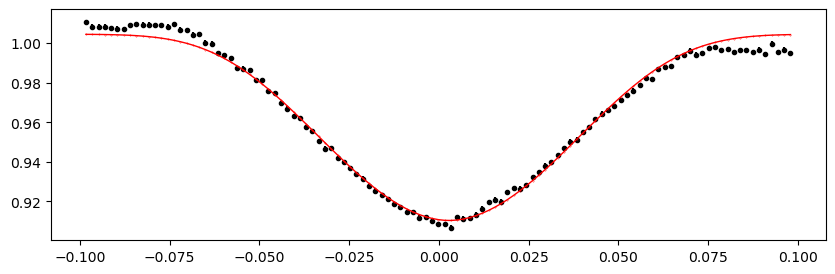

2310.8931615 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.22it/s]


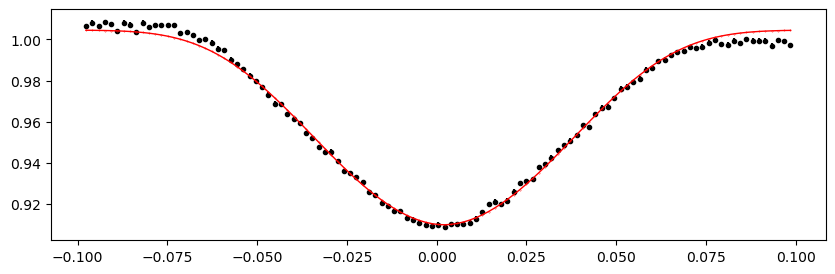

2311.6857305000003 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.18it/s]


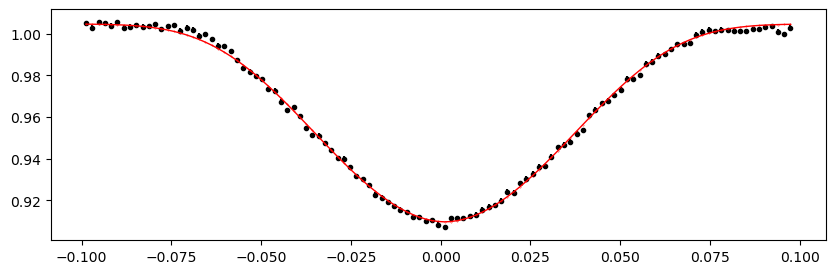

2312.4782995 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.43it/s]


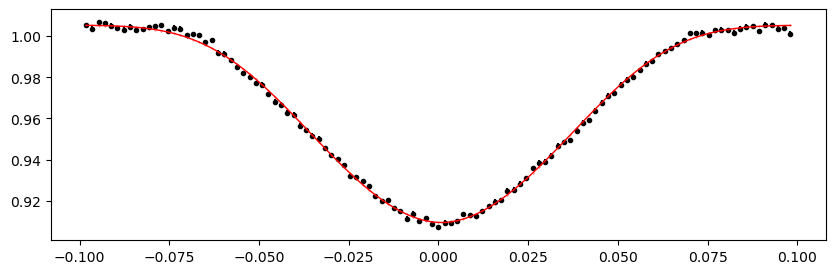

2313.2708685000002 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.03it/s]


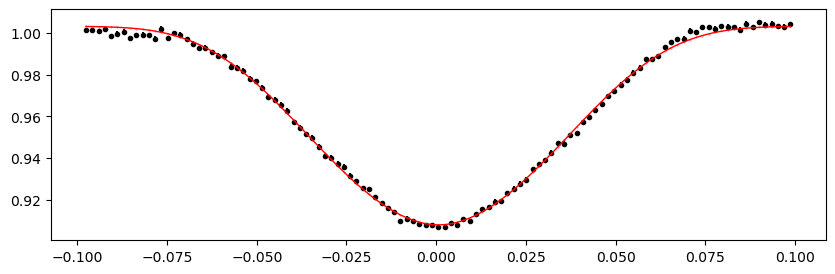

2314.0634375 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.42it/s]


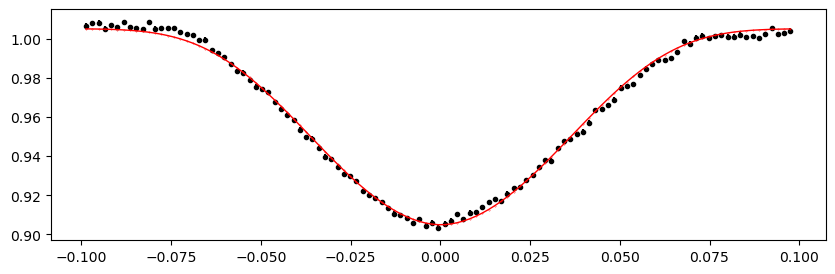

2314.8560065 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 310.78it/s]


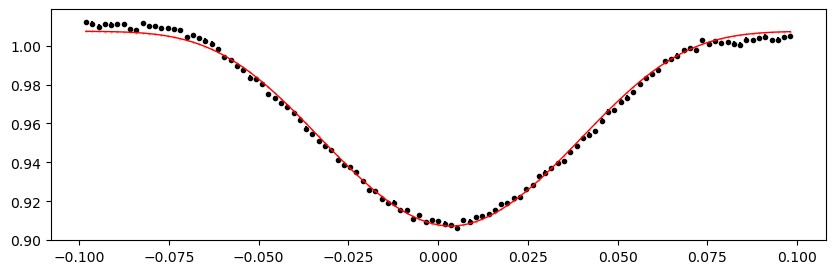

2315.6485755000003 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.65it/s]


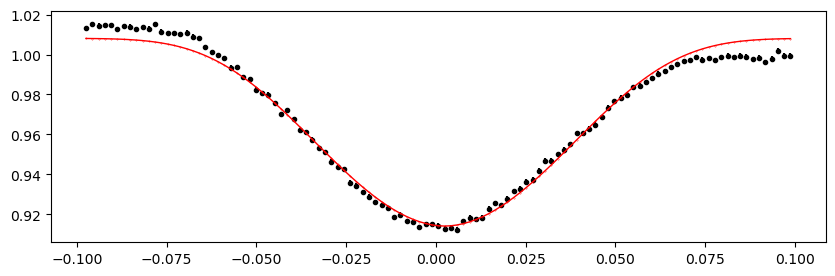

2316.4411445 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.09it/s]


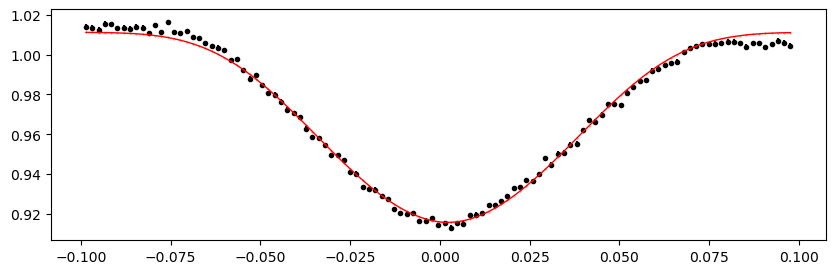

2317.2337135 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.65it/s]


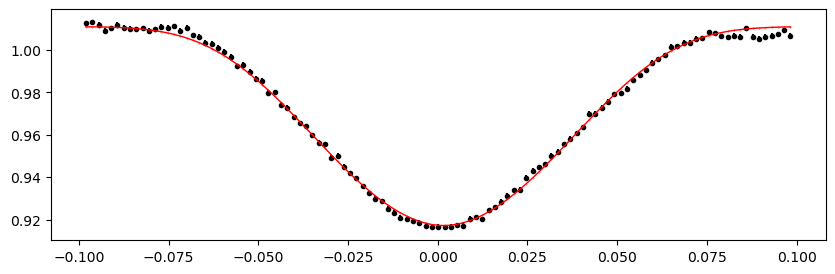

2318.0262825 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.23it/s]


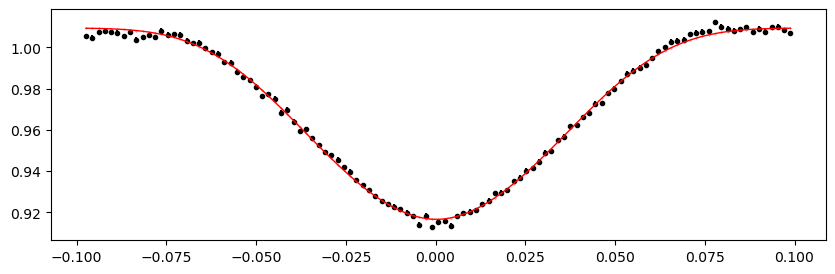

2318.8188515 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.35it/s]


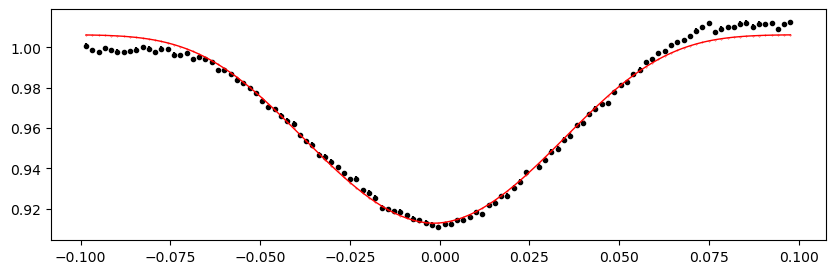

2322.7816965 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.80it/s]


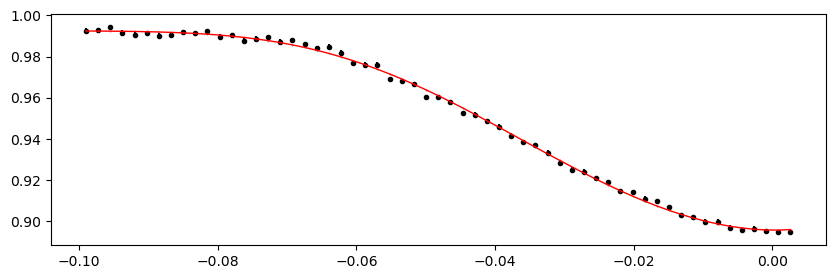

2323.5742655 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.08it/s]


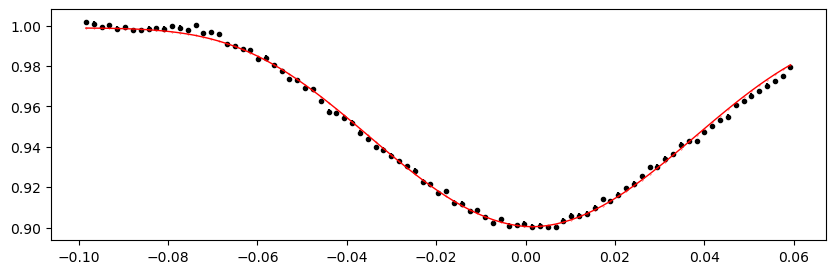

2324.3668345 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.26it/s]


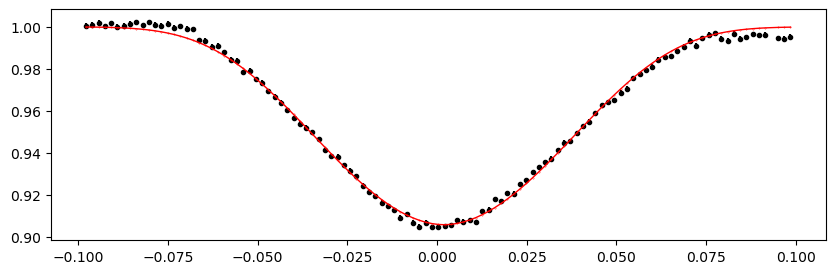

2325.1594035 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.04it/s]


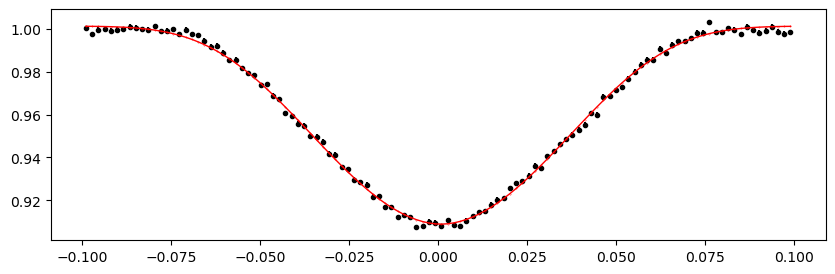

2325.9519725 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.15it/s]


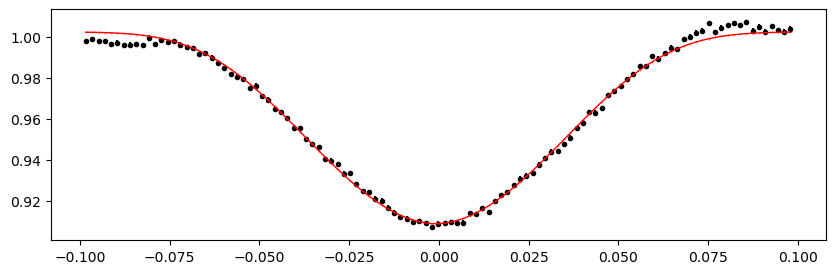

2326.7445415 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.04it/s]


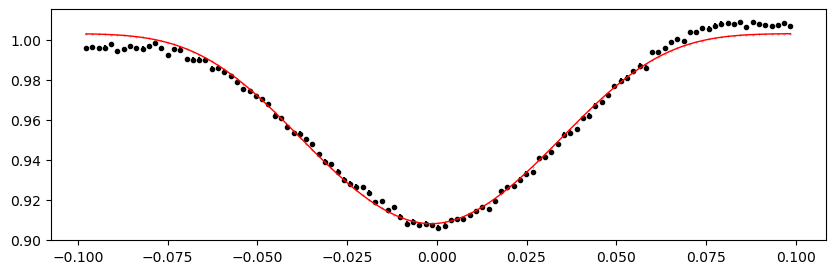

2327.5371105 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.48it/s]


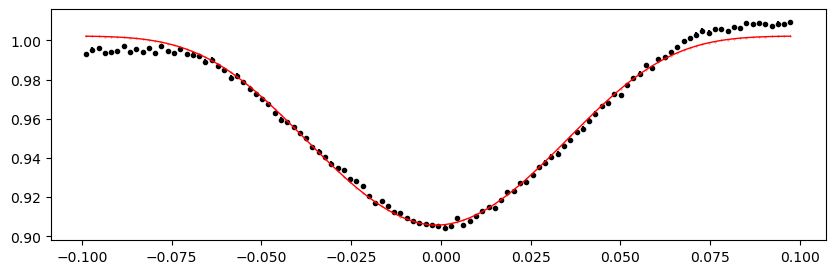

2328.3296795 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.74it/s]


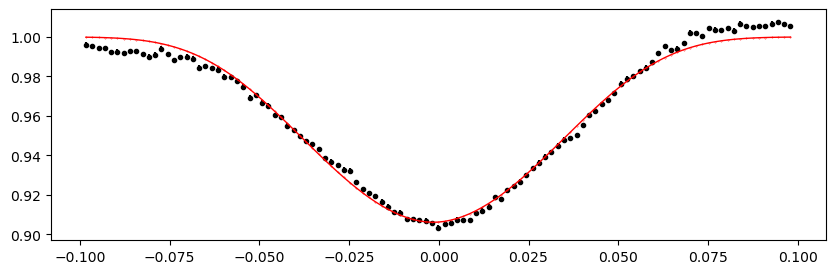

2329.1222485 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 353.49it/s]


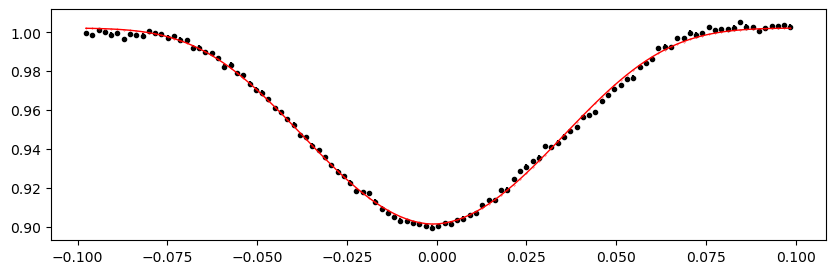

2329.9148175 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.18it/s]


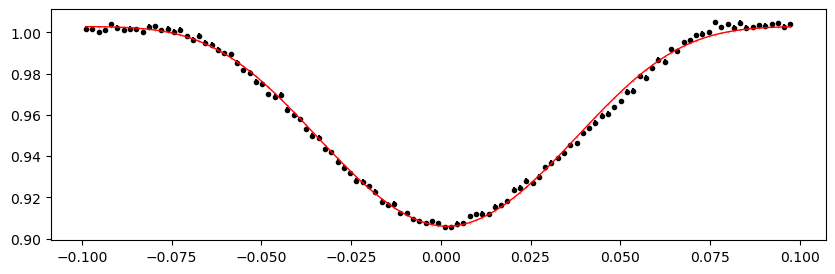

2330.7073865 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.28it/s]


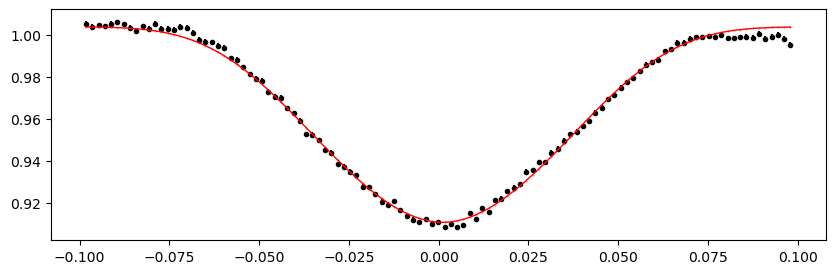

2331.4999555 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.60it/s]


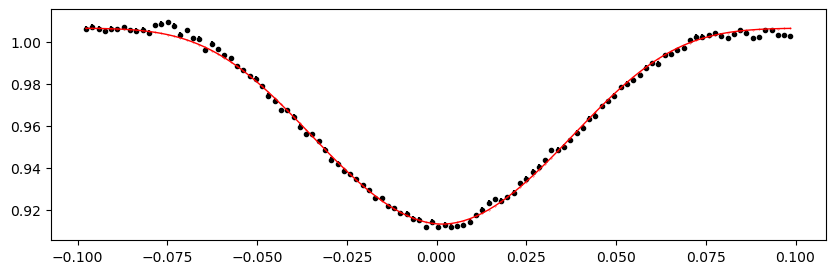

2332.2925245 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 354.43it/s]


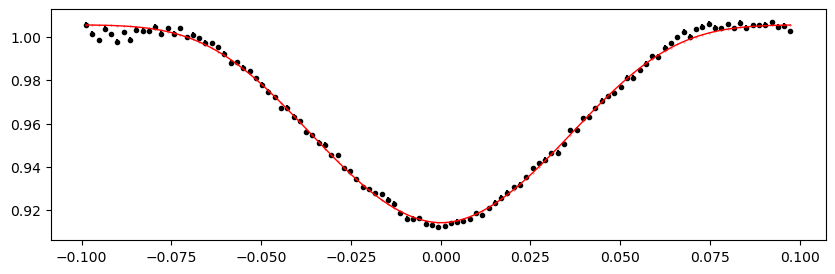

3041.6417794999998 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.05it/s]


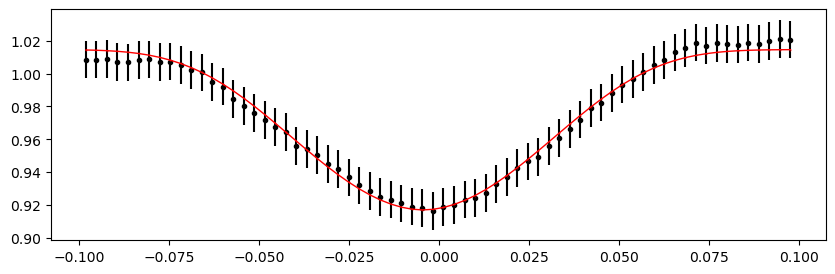

3042.4343485 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.26it/s]


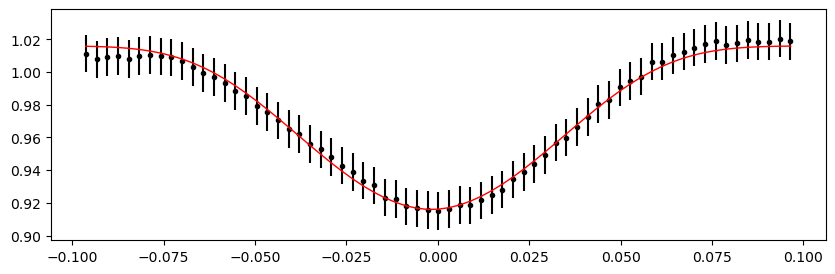

3043.2269175 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.22it/s]


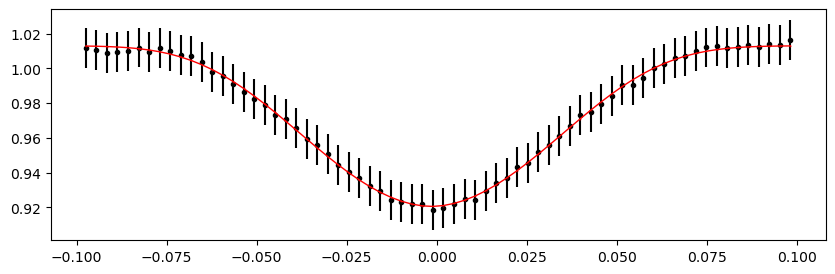

3044.0194865000003 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.25it/s]


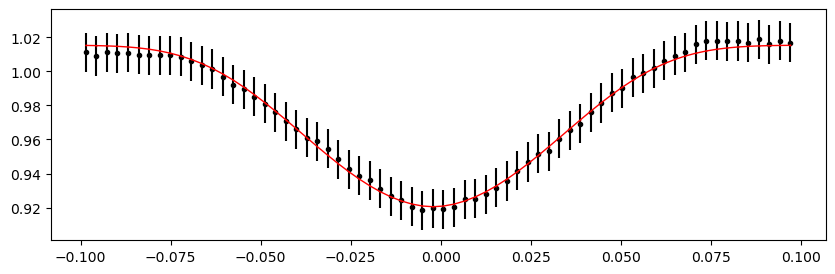

3044.8120555 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.71it/s]


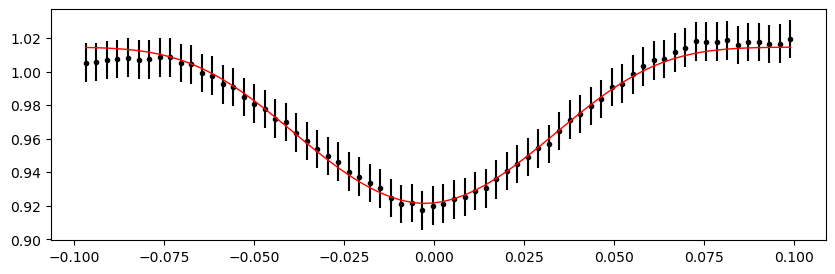

3045.6046244999998 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 357.66it/s]


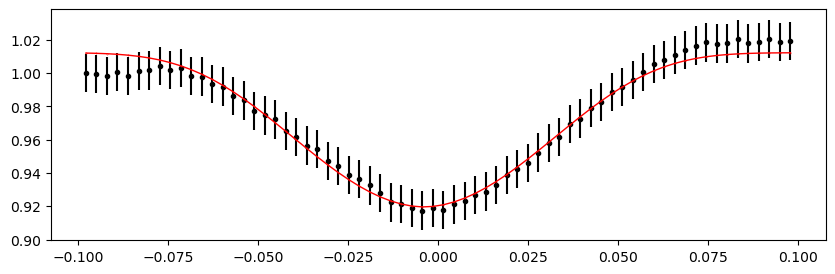

3046.3971935 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.15it/s]


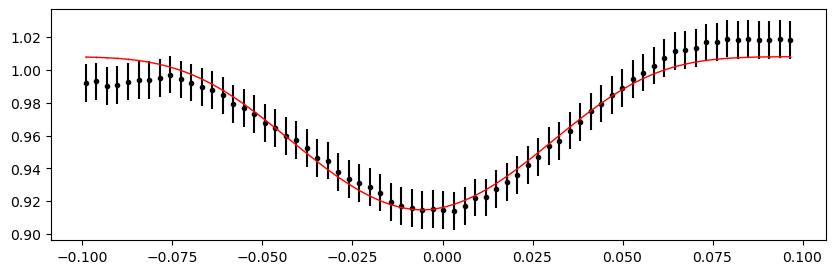

3047.1897625 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.90it/s]


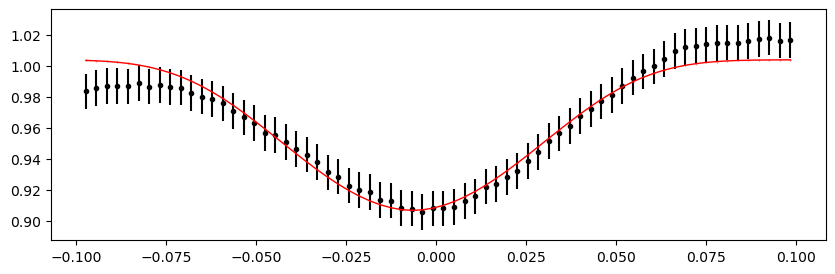

3047.9823315000003 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.66it/s]


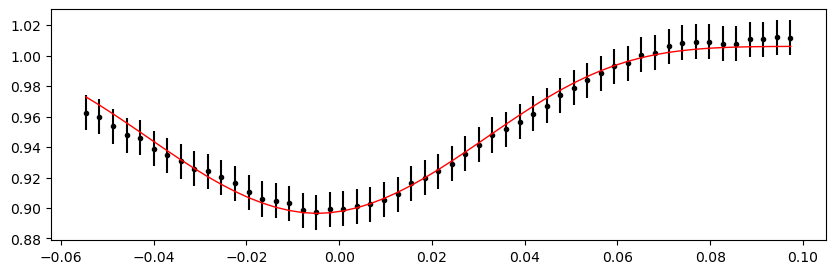

3048.7749005 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 373.36it/s]


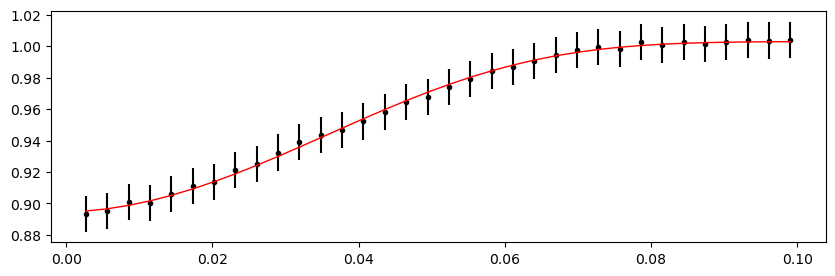

3049.5674695 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 490.11it/s]


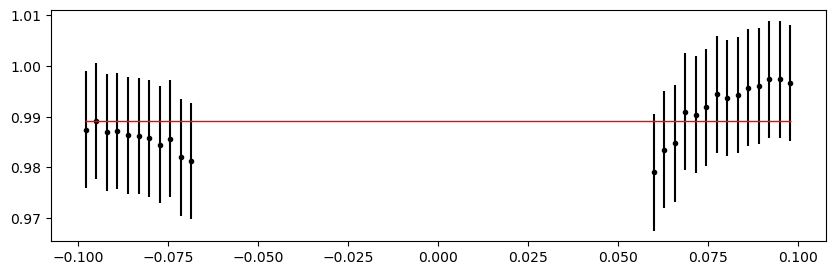

3050.3600385 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.07it/s]


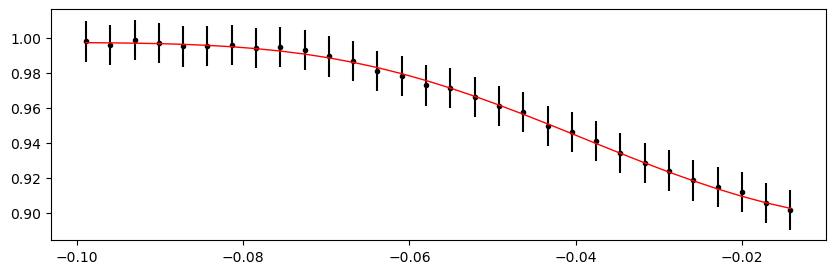

3051.1526075 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.76it/s]


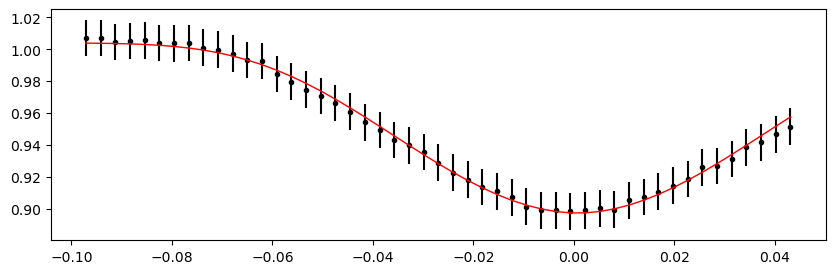

3051.9451765000003 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.19it/s]


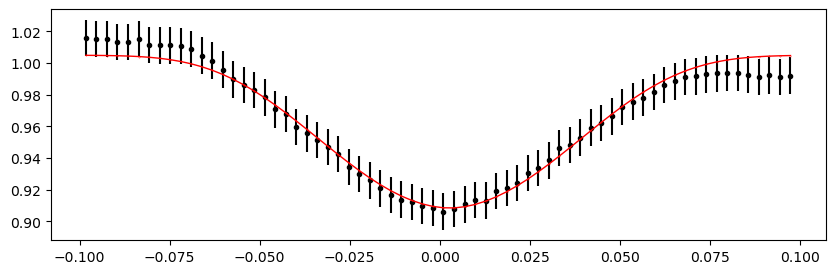

3052.7377455 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.23it/s]


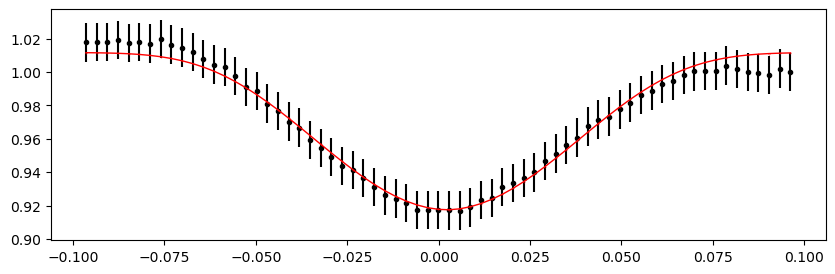

3053.5303145 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.22it/s]


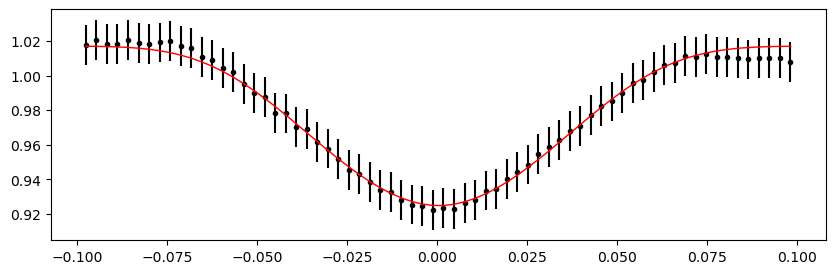

3054.3228835 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.51it/s]


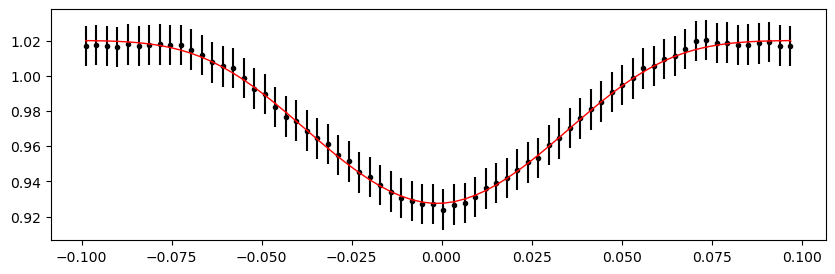

3055.1154525 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 440.63it/s]


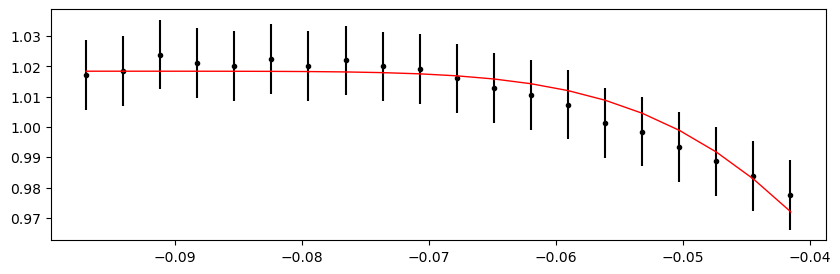

3055.9080215000004 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.46it/s]


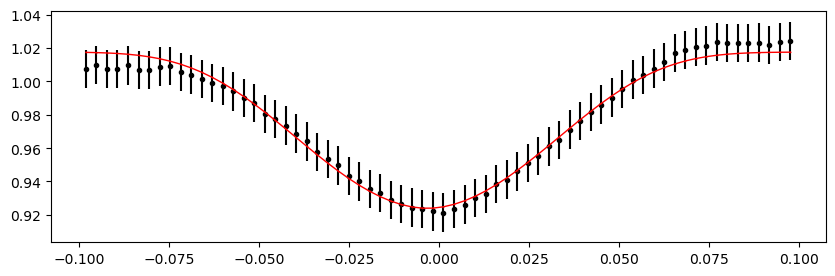

3056.7005905 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.71it/s]


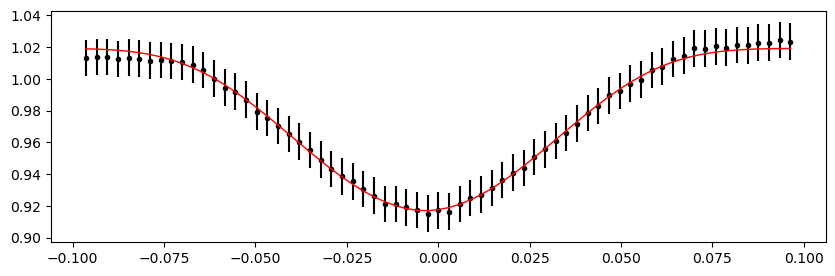

3057.4931595 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.04it/s]


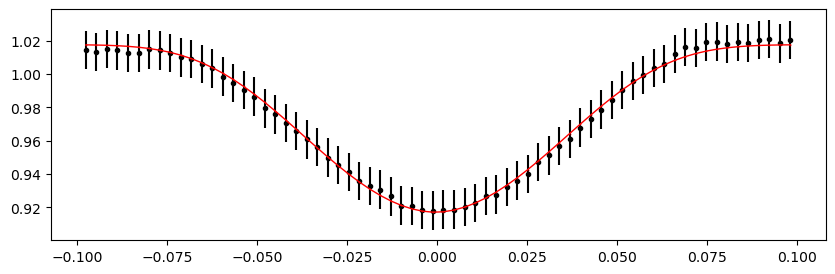

3058.2857285 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.38it/s]


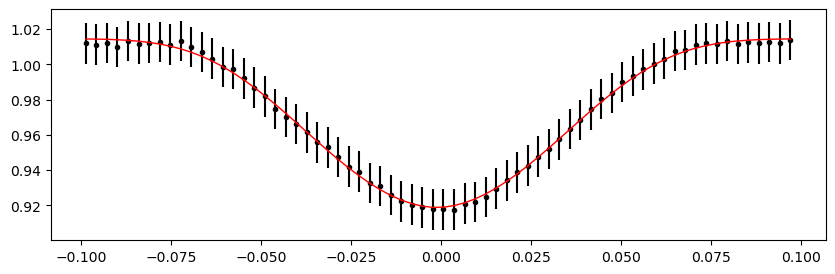

3059.0782975 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.37it/s]


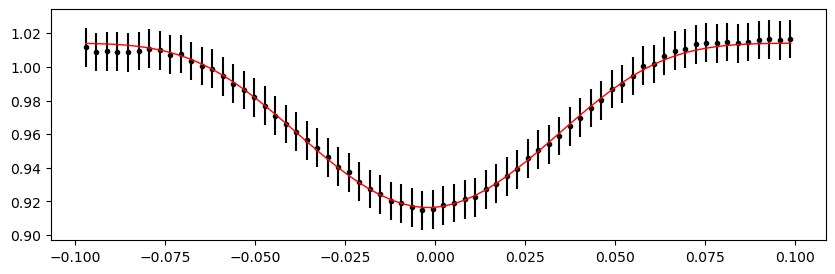

3059.8708665000004 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.20it/s]


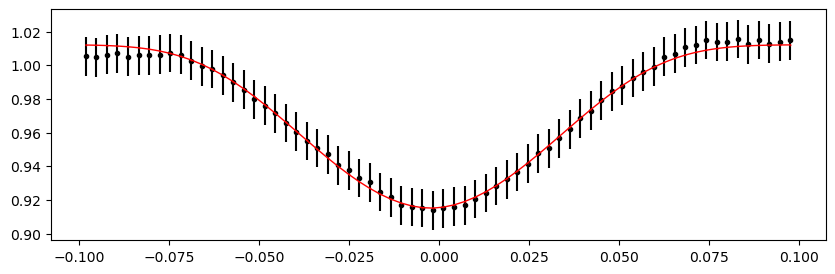

3060.6634355 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.24it/s]


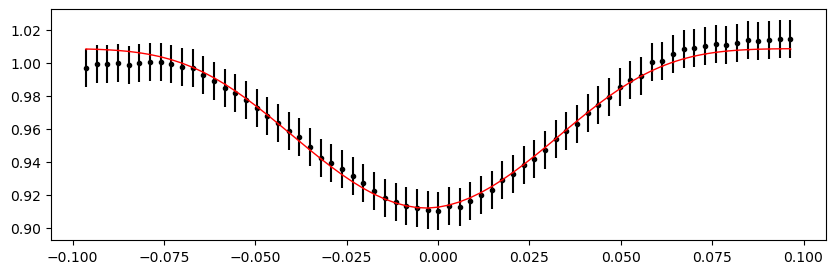

3061.4560045 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.93it/s]


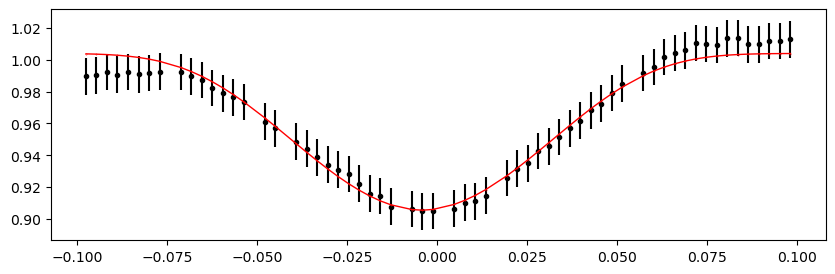

3062.2485735 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.06it/s]


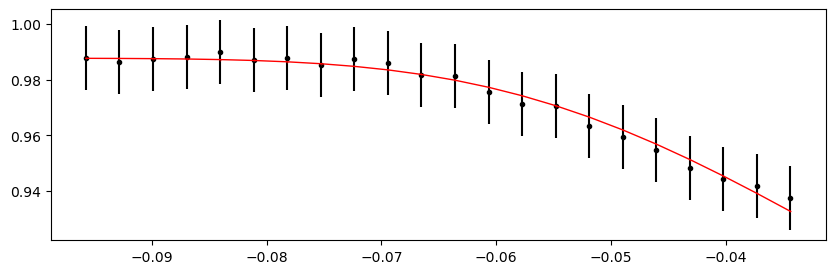

3063.0411425 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.80it/s]


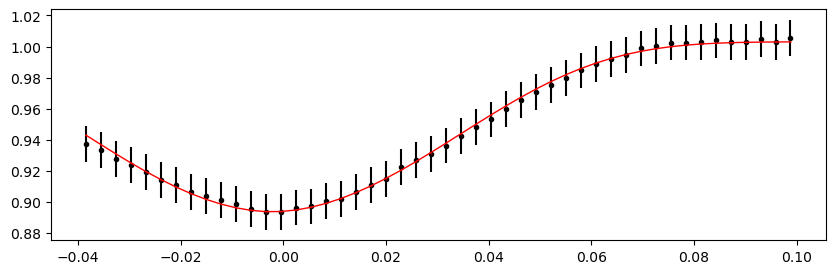

3063.8337115 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.83it/s]


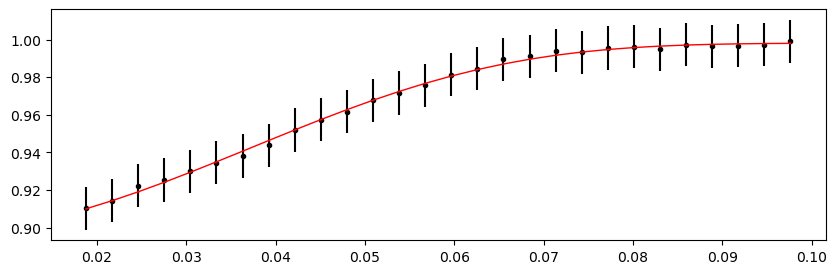

3064.6262805 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 509.31it/s]


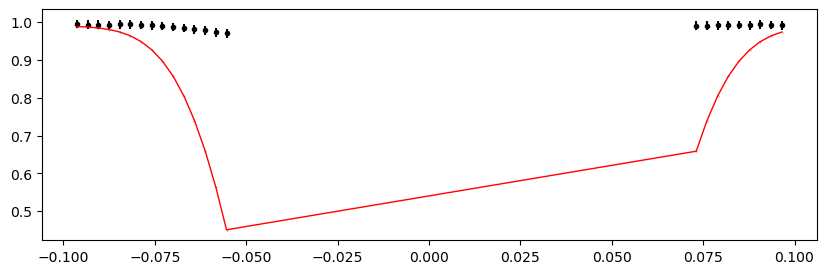

3065.4188495 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.57it/s]


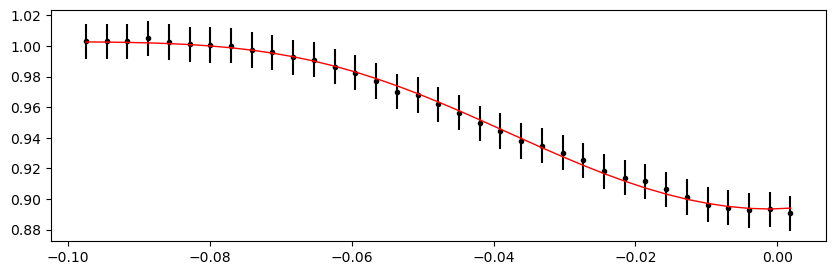

3066.2114185 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.53it/s]


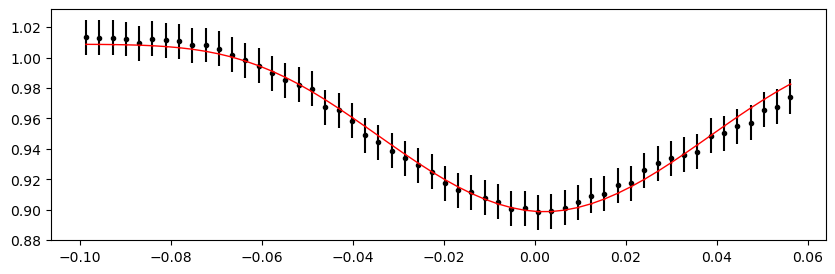

3067.0039875 1.0042921987806457 -0.09526108256267735 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.52it/s]


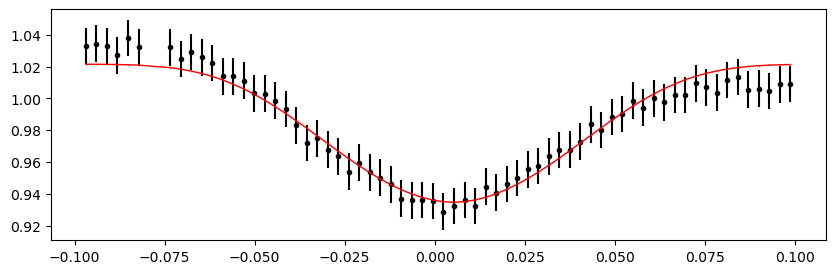

In [39]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=4,  # for 30 min cadence data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

Note: 3 data points in df_primary filtered out due to huge O-C error.
Note: 4 data points in in_df_secondary filtered out due to huge O-C error.


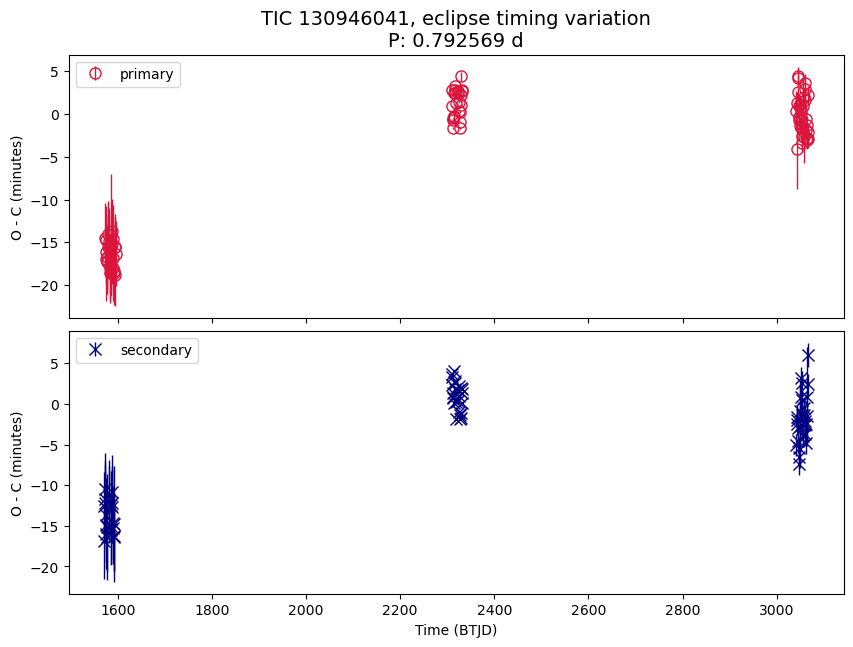

In [40]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

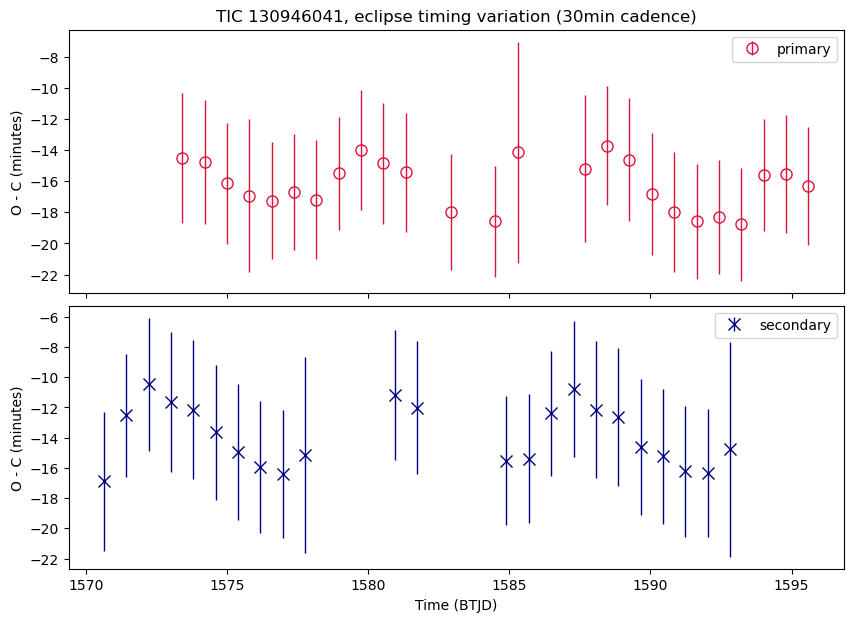

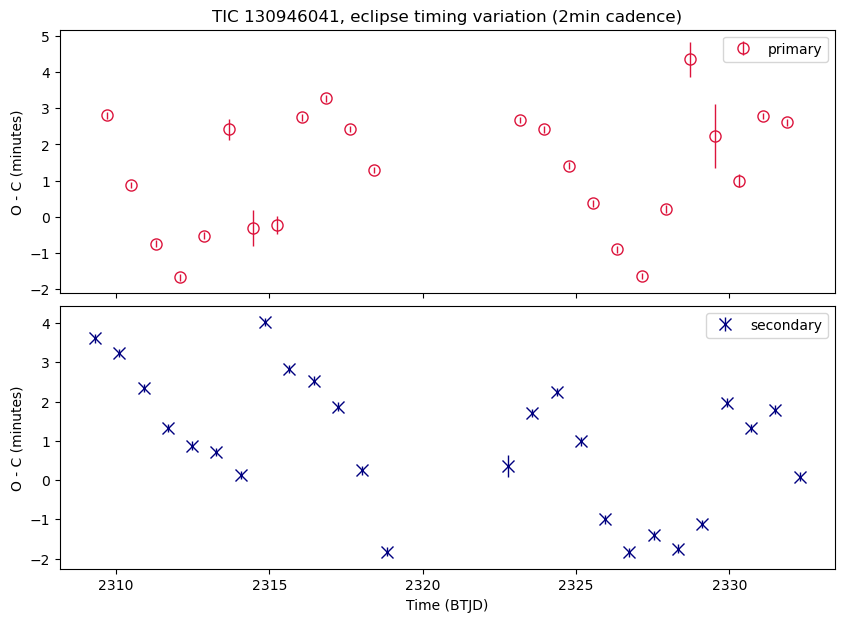

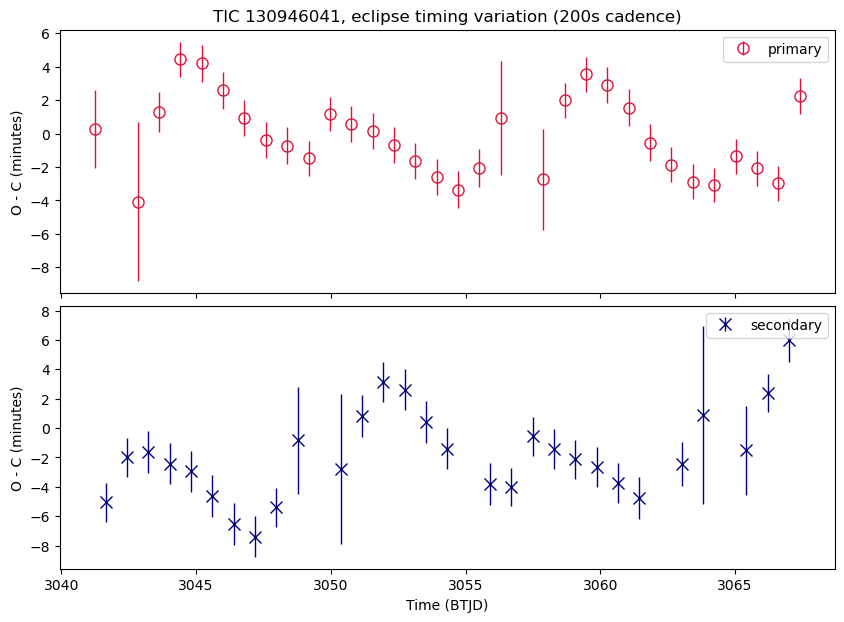

In [42]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1500, 1700),
    (2200, 2400),
    (3000, 3200),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[0][0]
    ax.set_title(f"{ax.get_title()} (30min cadence)")
    ax = axs_list[1][0]
    ax.set_title(f"{ax.get_title()} (2min cadence)")
    ax = axs_list[2][0]
    ax.set_title(f"{ax.get_title()} (200s cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges) 
tweak_axs_list(axs_list);

## make a periodogram 

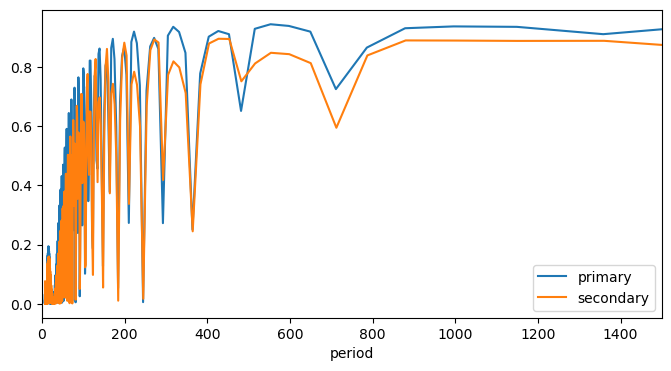

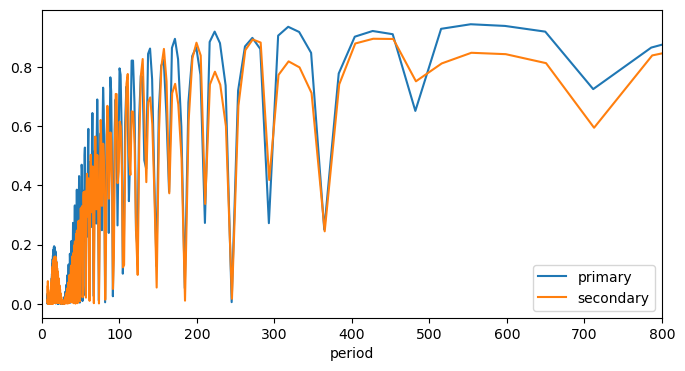

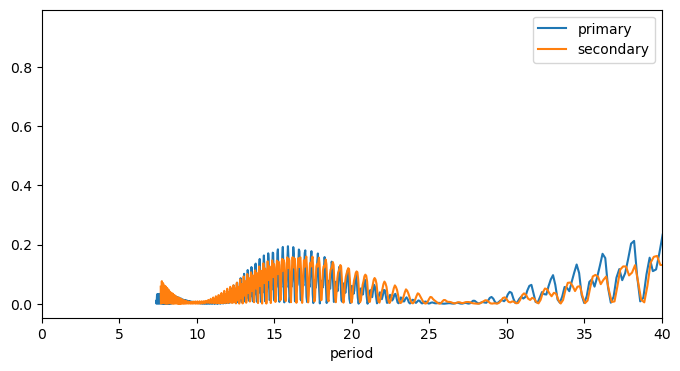

In [45]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1500)
plt.show()

if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 800)
    plt.show()
    
if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 40)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [46]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

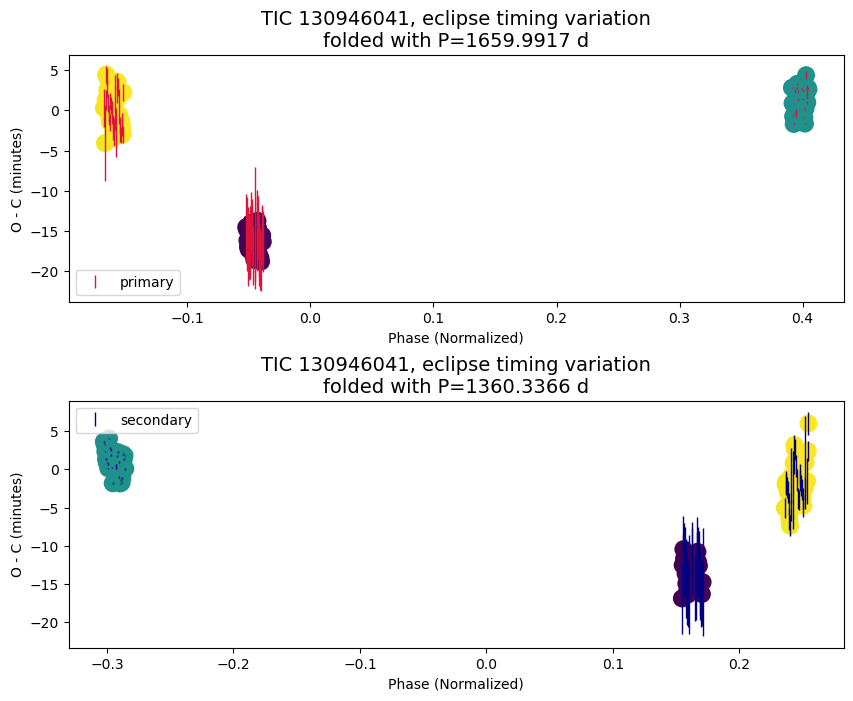

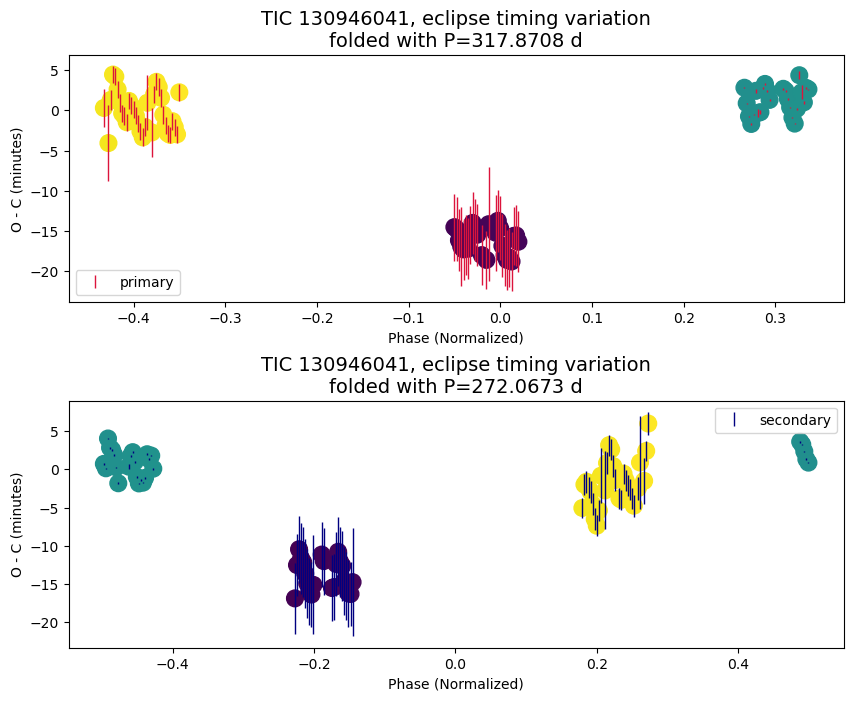

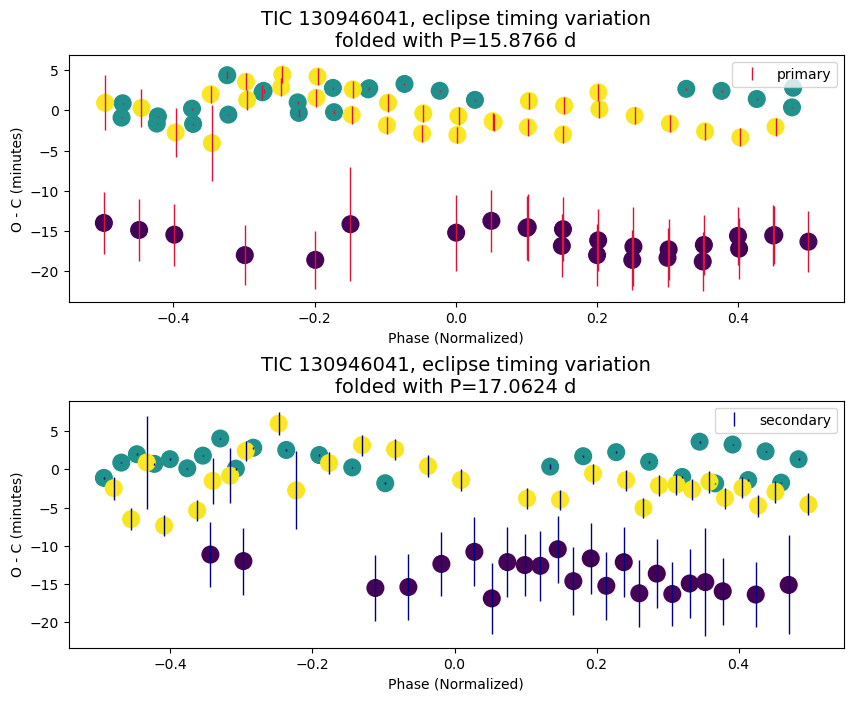

In [75]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=1000, period_max=None,
        period_min_s=1000, period_max_s=None
    )

    axs = plot_oc_folded(
        period_min=None, period_max=400,
        period_min_s=None, period_max_s=400
    )

    axs = plot_oc_folded(
        period_min=None, period_max=30,
        period_min_s=None, period_max_s=30
    )


    tweak_axs(axs)

## Run custom indiviual fit (per-sector for sector 10)

- to reconfirm the O-C in sector 10 (30 min cadence data) is indeed about -15 - 20 minutes aove

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [03:13<00:00, 15.49it/s]


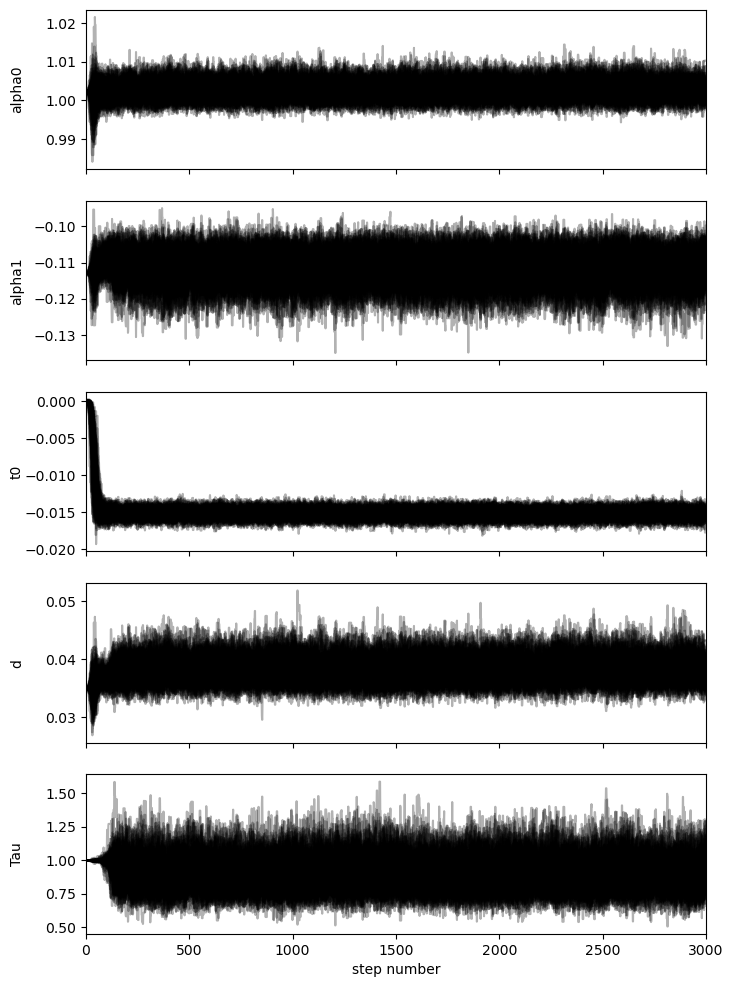

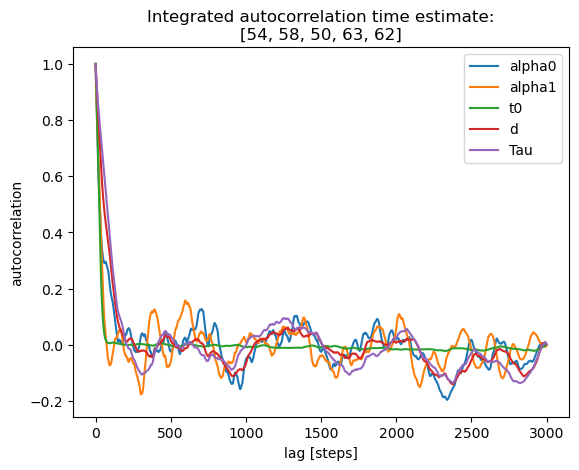

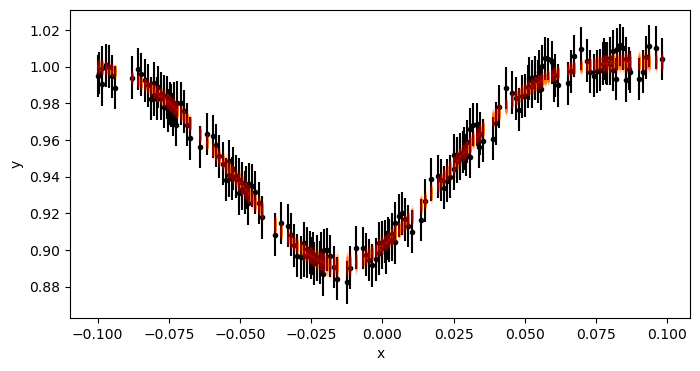

10 1584.0548298095523
number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau
10,1584.0548298095523,1.0026768357161213,-0.1114333908829793,-0.015157307276306771,0.000655632925596443,0.03807248206292442,0.8902862141953767

shift_mins: -17.29902509377226  ; std_min: 0.748273438378148


In [74]:
from types import SimpleNamespace

etv_out_str = "number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau\n"


# convert lc to the form needed by fit etv_functions
lc_f_data = data_primary[(1570 < data_primary.time) & (data_primary.time < 1599)].copy()
lc_f_data.phase = lc_f_data.phase - mean_t0   # shift expected in to 0 phase  to make the result comparable to the regular runs above

start_vals = [mean_alpha0, mean_alpha1, 0, mean_d, mean_Tau]  
_alpha0, _alpha1, _t0, _d, _Tau, _fit_params_stats = etv_functions.run_mcmc_initial_fit(
    lc_f_data, start_vals, 
    # nruns=20, discard=1, 
    nruns=3000, discard=1000,
    autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)

_stdv_t0 = _fit_params_stats["std_t0"]
_t = np.mean(lc_f_data.time)  # approximate transit time 
_sector = 10
print(_sector, _t)

etv_out_str += ",".join([str(s) for s in [_sector, _t, _alpha0, _alpha1, _t0, _stdv_t0, _d, _Tau]])
etv_out_str += "\n"

print(etv_out_str)

# --- O-C in minutes ---
print("shift_mins:", _t0 * period * 24 * 60, " ; std_min:", _stdv_t0 * period * 24 * 60)  


## Results Summary

In [48]:
# FILL-IN the ETV results / comments
has_etv = "Y"
comments = "O-C shows non-linar ETA with a period of ~15 d. Possibly some longer term ETV (in hundreds of days or more), but uncertain if the O-C from 30 min cadence data (sector 10, BTJD 1500-ish) is reliable."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))

0
tic                                                                                                                                                                                                       130946041
has_etv                                                                                                                                                                                                           Y
comments     O-C shows non-linar ETA with a period of ~15 d. Possibly some longer term ETV (in hundreds of days or more), but uncertain if the O-C from 30 min cadence data (sector 10, BTJD 1500-ish) is reliable.
period                                                                                                                                                                                                     0.792569
depth_pct_p                                                                                                                                                                                                    11.3
depth_pct_s                                                                                                                                                                                                    9.53
epoch_p                                                                                                                                                                                                     1571.03
epoch_s                                                                                                                                                                                                 1570.633716
num_sectors                                                                                                                                                                                                       3
time_span                                                                                                                                                                                                   1498.58
time_start                                                                                                                                                                                                  1569.45
time_end                                                                                                                                                                                                    3068.03


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
130946041,Y,"O-C shows non-linar ETA with a period of ~15 d. Possibly some longer term ETV (in hundreds of days or more), but uncertain if the O-C from 30 min cadence data (sector 10, BTJD 1500-ish) is reliable.",0.792569,11.3,9.53,1571.03,1570.6337155,3,1498.58,1569.45,3068.03

